In [1]:
# System things
import os

# Data manipulation
import pandas as pd
import numpy as np

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

# Data analytics
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model, svm, neighbors, ensemble, neural_network

# Data pipeline for model fitting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
from sklearn import metrics
import shap

# Read in data

In [2]:
raw_data = pd.read_csv('../data/03_analytic/clean_data.csv').drop(['Unnamed: 0'], axis=1)
data = raw_data.copy()
data.describe()

Status  Progress  Duration (in seconds)  Finished  credential  \
count    44.0      44.0              44.000000      44.0   43.000000   
mean      0.0     100.0             944.409091       1.0    4.348837   
std       0.0       0.0             640.976773       0.0    1.702711   
min       0.0     100.0             270.000000       1.0    1.000000   
25%       0.0     100.0             601.750000       1.0    3.000000   
50%       0.0     100.0             846.000000       1.0    5.000000   
75%       0.0     100.0            1002.500000       1.0    6.000000   
max       0.0     100.0            4018.000000       1.0    6.000000   

       years_experience_aba        age     gender  low_low_low_low  \
count             44.000000  43.000000  44.000000        44.000000   
mean               4.659091  34.139535   1.681818         1.409091   
std                7.451216  10.176026   0.471155         0.497350   
min                0.000000  19.000000   1.000000         1.000000   
25%                0.000000  26.500000   1.000000         1.000000   
50%                1.000000  34.000000   2.000000         1.000000   
75%                6.125000  40.000000   2.000000         2.000000   
max               30.000000  67.000000   2.000000         2.000000   

       low_low_med_low  low_low_high_low  low_low_low_med  low_low_med_med  \
count        44.000000         44.000000        44.000000        44.000000   
mean          1.431818          1.340909         1.272727         1.272727   
std           0.501056          0.479495         0.450511         0.450511   
min           1.000000          1.000000         1.000000         1.000000   
25%           1.000000          1.000000         1.000000         1.000000   
50%           1.000000          1.000000         1.000000         1.000000   
75%           2.000000          2.000000         2.000000         2.000000   
max           2.000000          2.000000         2.000000         2.000000   

       low_low_high_med  low_low_low_high  low_low_med_high  \
count         44.000000         44.000000         43.000000   
mean           1.227273          1.250000          1.255814   
std            0.423915          0.438019          0.441481   
min            1.000000          1.000000          1.000000   
25%            1.000000          1.000000          1.000000   
50%            1.000000          1.000000          1.000000   
75%            1.000000          1.250000          1.500000   
max            2.000000          2.000000          2.000000   

       low_low_high_high  low_med_low_low  low_med_med_low  low_med_high_low  \
count          44.000000        44.000000        44.000000         44.000000   
mean            1.272727         1.772727         1.750000          1.704545   
std             0.450511         0.423915         0.438019          0.461522   
min             1.000000         1.000000         1.000000          1.000000   
25%             1.000000         2.000000         1.750000          1.000000   
50%             1.000000         2.000000         2.000000          2.000000   
75%             2.000000         2.000000         2.000000          2.000000   
max             2.000000         2.000000         2.000000          2.000000   

       low_med_low_med  low_med_med_med  low_med_high_med  low_med_low_high  \
count        44.000000        44.000000         44.000000         44.000000   
mean          1.568182         1.500000          1.431818          1.386364   
std           0.501056         0.505781          0.501056          0.492545   
min           1.000000         1.000000          1.000000          1.000000   
25%           1.000000         1.000000          1.000000          1.000000   
50%           2.000000         1.500000          1.000000          1.000000   
75%           2.000000         2.000000          2.000000          2.000000   
max           2.000000         2.000000          2.000000          2.000000   

       low_med_med_high

# Look at initial differences across questions

In [3]:
# Prep dataframe
plot_df = data[[col for col in list(data) if (col.startswith("low_")) or (col.startswith("med_")) or (col.startswith("high_")) or (col=='source') or (col=='ResponseId')]]
plot_df = plot_df.melt(id_vars=['source', 'ResponseId'])
plot_df.columns=['source', 'participant', 'scenario', 'choice']
plot_df[::300]

source        participant           scenario  choice
0     bx_analyst  R_2w6NcI6Jrx51rF1    low_low_low_low     1.0
300      gen_pop  R_2t6bJGRlYY80ZJU   low_low_low_high     1.0
600      gen_pop  R_2WAxCMC47DE4zYK    low_med_med_med     2.0
900      gen_pop  R_1XknF4I91TcKDUB  low_high_high_low     2.0
1200  bx_analyst  R_31jbdooORELfOCE  low_low_low_low.1     2.0
1500  bx_analyst  R_29fSUFKp0RL7akz   med_low_med_high     1.0
1800     gen_pop  R_DNuRbZzZkCBQlIl    med_med_med_med     2.0
2100     gen_pop  R_1OuxL5R9bmTa6Sg  med_high_high_low     2.0
2400     gen_pop  R_3HkuxDHBavmuvaa   high_low_low_low     1.0
2700     gen_pop  R_1gHCuKRpyugis8D  high_low_med_high     2.0
3000  bx_analyst  R_aUX4jDNUAXSAcXD  high_med_high_med     2.0
3300  bx_analyst  R_2w6NcI6Jrx51rF1  high_high_low_med     1.0

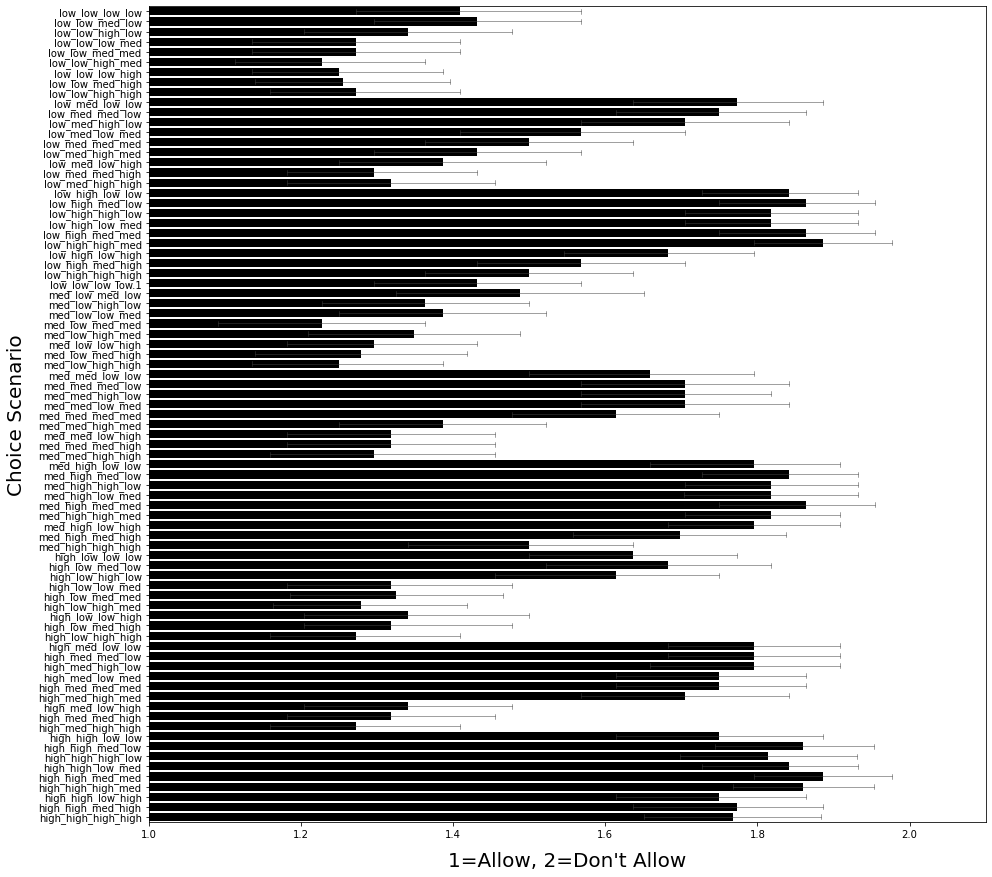

In [4]:
# All conditions all respondents
fig, ax = plt.subplots(figsize=(15, 15))
sns.barplot(y='scenario', x='choice', data=plot_df, color='k', errwidth=.5, capsize=.5)
plt.ylabel("Choice Scenario", fontsize=20, labelpad=12)
plt.xlim(1, 2.1)
plt.xlabel("1=Allow, 2=Don't Allow", fontsize=20, labelpad=12)
plt.show()

In [5]:
# Make the long df easier to groupby different choice scenario characteristics
choice_char = []

for i in range(len(plot_df)):
    val = plot_df['scenario'][i].split("_")
    choice_char.append(val)

choice_char = pd.DataFrame(choice_char)
choice_char.columns = ['first_tele', 'first_harm', 'sec_tele', 'sec_harm']
plot_df = pd.concat([plot_df, choice_char], axis=1)
plot_df = plot_df.replace('low.1', 'low')
plot_df

source        participant             scenario  choice first_tele  \
0     bx_analyst  R_2w6NcI6Jrx51rF1      low_low_low_low     1.0        low   
1     bx_analyst  R_u4UBRJcTeUC1yPT      low_low_low_low     1.0        low   
2     bx_analyst  R_25Kjw8pvt3nUO7o      low_low_low_low     1.0        low   
3     bx_analyst  R_cZaE8YMWB2XuGxb      low_low_low_low     1.0        low   
4     bx_analyst  R_29fSUFKp0RL7akz      low_low_low_low     1.0        low   
...          ...                ...                  ...     ...        ...   
3559     gen_pop  R_6Gy2uOTOvzkY0QF  high_high_high_high     2.0       high   
3560     gen_pop  R_DNuRbZzZkCBQlIl  high_high_high_high     2.0       high   
3561     gen_pop  R_vlu8srmFxMtgo8x  high_high_high_high     2.0       high   
3562     gen_pop  R_24FTAEpNvAaeEux  high_high_high_high     2.0       high   
3563     gen_pop  R_dbxYDzt60TG72sF  high_high_high_high     2.0       high   

     first_harm sec_tele sec_harm  
0           low      low      low  
1           low      low      low  
2           low      low      low  
3           low      low      low  
4           low      low      low  
...         ...      ...      ...  
3559       high     high     high  
3560       high     high     high  
3561       high     high     high  
3562       high     high     high  
3563       high     high     high  

[3564 rows x 8 columns]

# Plots of main effects

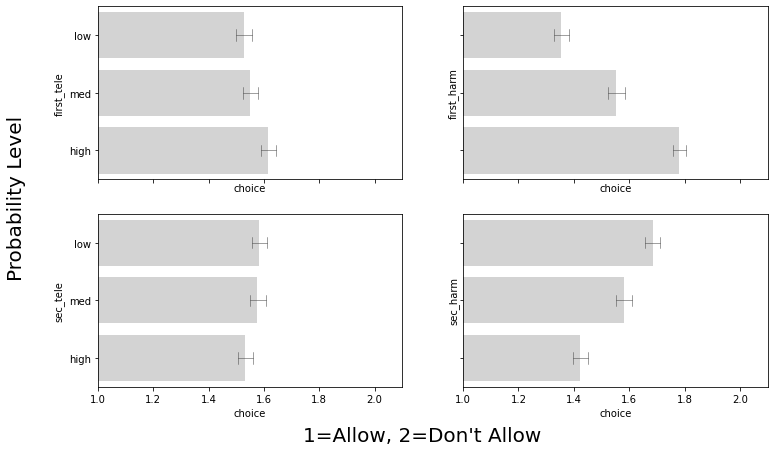

In [6]:
# Choice scenario characteristics
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 7), sharex=True, sharey=True)
sns.barplot(ax=ax[0, 0], y='first_tele', x='choice', data=plot_df, color='lightgray', errwidth=.5, capsize=.2)
sns.barplot(ax=ax[0, 1], y='first_harm', x='choice', data=plot_df, color='lightgray', errwidth=.5, capsize=.2)
sns.barplot(ax=ax[1, 0], y='sec_tele', x='choice', data=plot_df, color='lightgray', errwidth=.5, capsize=.2)
sns.barplot(ax=ax[1, 1], y='sec_harm', x='choice', data=plot_df, color='lightgray', errwidth=.5, capsize=.2)
fig.supylabel("Probability Level", fontsize=20)
fig.supxlabel("1=Allow, 2=Don't Allow", fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(1, 2.1)
plt.show()

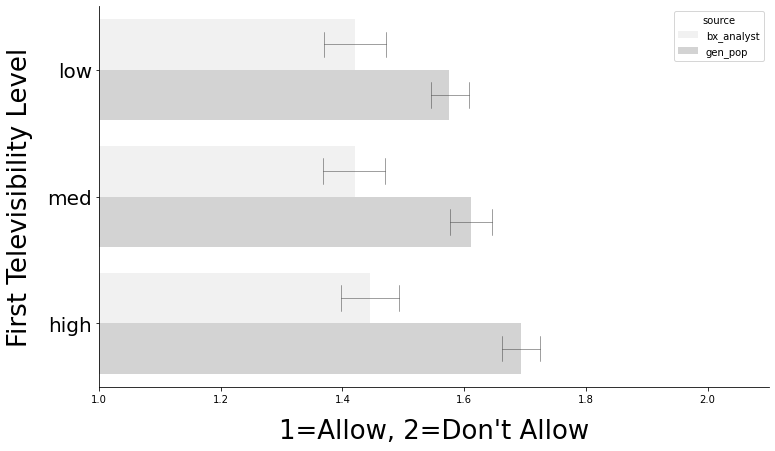

In [7]:
# Choice scenario characteristics
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(y='first_tele', x='choice', data=plot_df, hue='source', color='lightgray', errwidth=.5, capsize=.2)
plt.ylabel("First Televisibility Level", fontsize=26, labelpad=14)
plt.xlabel("1=Allow, 2=Don't Allow", fontsize=26, labelpad=14)
plt.yticks(fontsize=20)
plt.xlim(1, 2.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

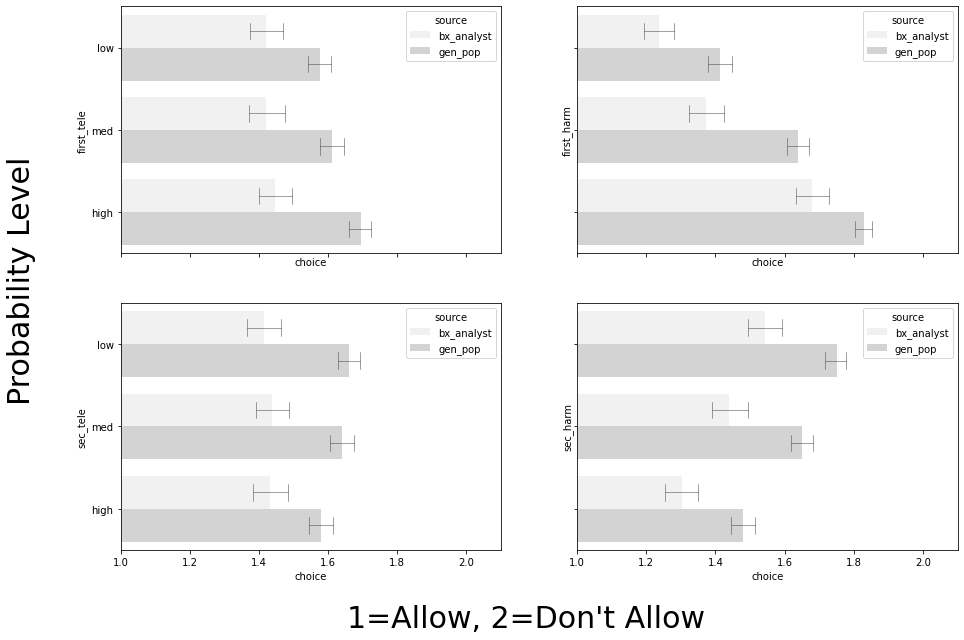

In [8]:
# Choices by scenario and group
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10), sharex=True, sharey=True)
sns.barplot(ax=ax[0, 0], y='first_tele', x='choice', data=plot_df, hue='source', color='lightgray', errwidth=.5, capsize=.2)
sns.barplot(ax=ax[0, 1], y='first_harm', x='choice', data=plot_df, hue='source', color='lightgray', errwidth=.5, capsize=.2)
sns.barplot(ax=ax[1, 0], y='sec_tele', x='choice', data=plot_df, hue='source', color='lightgray', errwidth=.5, capsize=.2)
sns.barplot(ax=ax[1, 1], y='sec_harm', x='choice', data=plot_df, hue='source', color='lightgray', errwidth=.5, capsize=.2)
fig.supylabel("Probability Level", fontsize=30)
fig.supxlabel("1=Allow, 2=Don't Allow", fontsize=30)
plt.yticks(fontsize=20)
plt.xlim(1, 2.1)
plt.show()

# Statistics

In [9]:
# Check for statistical significance using logistics regression model
features = plot_df[['source', 'first_tele', 'first_harm', 'sec_tele', 'sec_harm']]
fit_dict = {'bx_analyst':0, 'gen_pop':1, 
            'low':0, 'med':1, 'high':2}
features = features.replace(fit_dict)
dv = plot_df['choice']
dv = dv.replace(1, 0)
dv = dv.replace(2, 1)
log_res = sm.Logit(dv, features, missing='drop').fit()
log_res.summary()

Optimization terminated successfully.
         Current function value: 0.577112
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 choice   No. Observations:                 3553
Model:                          Logit   Df Residuals:                     3548
Method:                           MLE   Df Model:                            4
Date:                Mon, 20 Jun 2022   Pseudo R-squ.:                  0.1576
Time:                        16:38:39   Log-Likelihood:                -2050.5
converged:                       True   LL-Null:                       -2434.1
Covariance Type:            nonrobust   LLR p-value:                1.003e-164
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
source         0.6895      0.071      9.732      0.000       0.551       0.828
first_tele     0.0936      0.042      2.209      0.027       0.011       0.177
first_harm     0.8998      0.046     19.651      0.000       0.810       0.990
sec_tele      -0.2707      0.043     -6.363      0.000      -0.354      -0.187
sec_harm      -0.7834      0.045    -17.392      0.000      -0.872      -0.695
==============================================================================
"""

In [10]:
# Convert entire df to numbers
num_df = plot_df.replace(fit_dict)
num_df['choice'] = num_df['choice'].replace(1, 0)
num_df['choice'] = num_df['choice'].replace(2, 1)
num_df.dropna(inplace=True)
num_df = num_df.reset_index(drop=True)
num_df

source        participant             scenario  choice  first_tele  \
0          0  R_2w6NcI6Jrx51rF1      low_low_low_low     0.0           0   
1          0  R_u4UBRJcTeUC1yPT      low_low_low_low     0.0           0   
2          0  R_25Kjw8pvt3nUO7o      low_low_low_low     0.0           0   
3          0  R_cZaE8YMWB2XuGxb      low_low_low_low     0.0           0   
4          0  R_29fSUFKp0RL7akz      low_low_low_low     0.0           0   
...      ...                ...                  ...     ...         ...   
3548       1  R_6Gy2uOTOvzkY0QF  high_high_high_high     1.0           2   
3549       1  R_DNuRbZzZkCBQlIl  high_high_high_high     1.0           2   
3550       1  R_vlu8srmFxMtgo8x  high_high_high_high     1.0           2   
3551       1  R_24FTAEpNvAaeEux  high_high_high_high     1.0           2   
3552       1  R_dbxYDzt60TG72sF  high_high_high_high     1.0           2   

      first_harm  sec_tele  sec_harm  
0              0         0         0  
1              0         0         0  
2              0         0         0  
3              0         0         0  
4              0         0         0  
...          ...       ...       ...  
3548           2         2         2  
3549           2         2         2  
3550           2         2         2  
3551           2         2         2  
3552           2         2         2  

[3553 rows x 8 columns]

In [11]:
# Check for statistical significance using a OLS linear regression model
reg_res = smf.ols('choice ~ source + first_tele + first_harm + sec_tele + sec_harm', data=num_df).fit()
reg_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 choice   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     188.5
Date:                Mon, 20 Jun 2022   Prob (F-statistic):          1.62e-178
Time:                        16:38:39   Log-Likelihood:                -2131.2
No. Observations:                3553   AIC:                             4274.
Df Residuals:                    3547   BIC:                             4311.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3323      0.022     15.046      0.000       0.289       0.376
source         0.1965      0.016     12.368      0.000       0.165       0.228
first_tele     0.0434      0.009      4.831      0.000       0.026       0.061
first_harm     0.2119      0.009     23.352      0.000       0.194       0.230
sec_tele      -0.0261      0.009     -2.885      0.004      -0.044      -0.008
sec_harm      -0.1315      0.009    -14.507      0.000      -0.149      -0.114
==============================================================================
Omnibus:                     1189.812   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.358
Skew:                          -0.161   Prob(JB):                     9.27e-41
Kurtosis:                       1.931   Cond. No.                         8.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# Check for statistical significance using a OLS linear regression model
reg_res = smf.ols('choice ~ source + first_tele + first_harm + sec_tele + sec_harm', data=plot_df).fit()
reg_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 choice   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     105.7
Date:                Mon, 20 Jun 2022   Prob (F-statistic):          8.52e-176
Time:                        16:38:39   Log-Likelihood:                -2127.3
No. Observations:                3553   AIC:                             4275.
Df Residuals:                    3543   BIC:                             4336.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.5262      0.025     61.651      0.000       1.478       1.575
source[T.gen_pop]     0.1965      0.016     12.375      0.000       0.165       0.228
first_tele[T.low]    -0.0868      0.018     -4.829      0.000      -0.122      -0.052
first_tele[T.med]    -0.0681      0.018     -3.719      0.000      -0.104      -0.032
first_harm[T.low]    -0.4247      0.018    -23.400      0.000      -0.460      -0.389
first_harm[T.med]    -0.2270      0.018    -12.536      0.000      -0.263      -0.192
sec_tele[T.low]       0.0513      0.018      2.832      0.005       0.016       0.087
sec_tele[T.med]       0.0441      0.018      2.434      0.015       0.009       0.080
sec_harm[T.low]       0.2621      0.018     14.457      0.000       0.227       0.298
sec_harm[T.med]       0.1593      0.018      8.791      0.000       0.124       0.195
==============================================================================
Omnibus:                     1181.866   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.708
Skew:                          -0.153   Prob(JB):                     2.12e-40
Kurtosis:                       1.932   Cond. No.                         6.83
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Above fits weren't great. Can we do better with ML?

In [13]:
# Prep data
features = num_df[['source', 'first_tele', 'first_harm', 'sec_tele', 'sec_harm']]
outc = num_df['choice']

In [14]:
# %% Functions
def fit_algo(model, features, outcome, save_name):
    scoring = {"MAE": "neg_mean_absolute_error",
               "r2": "r2"}
    cv = RepeatedKFold(n_splits=5,
                       n_repeats=10,
                       random_state=431979)
    scores = cross_validate(estimator=model,
                             X=features,
                             y=outcome,
                             groups=None,
                             scoring=scoring,
                             cv=cv,
                             n_jobs=1,
                             verbose=0)
    scores = pd.DataFrame(scores)
    scores['model'] = save_name
    scores.to_csv(f"../data/04_model_outputs/{save_name}.csv")
    print(f"AVG MAE: {abs(round(scores.test_MAE.mean(), 2))}; MAX MAE: {abs(round(scores.test_MAE.max(), 2))}")
    print(f"AVG r2: {round(scores.test_r2.mean(), 2)}; MAX r2: {round(scores.test_r2.max(), 2)}")
    return scores

In [15]:
# Set of all models to test
models = {"Linear Regression": linear_model.LinearRegression(),
          "LASSO Regression": linear_model.LassoCV(),
          "Elastic Net": linear_model.ElasticNetCV(),
          "Bayesian Ridge": linear_model.BayesianRidge(),
          "SGD": linear_model.SGDRegressor(),
          "SVM": svm.SVR(),
          "kNN": neighbors.KNeighborsRegressor(),
          "Random Forest": ensemble.RandomForestRegressor(),
          "ADABoost": ensemble.AdaBoostRegressor(),
          "GDB":ensemble.GradientBoostingRegressor(),
          "Multilayer Perceptron": neural_network.MLPRegressor()}

In [16]:
# Run through the list of models for all outcomes
import warnings
warnings.filterwarnings("ignore")

all_results = pd.DataFrame()

for key, value in models.items():
    print(f"Fitting {key}")
    results = fit_algo(model=value,
                       features=features,
                       outcome=outc,
                       save_name=key)
    all_results = pd.concat([all_results, results])
    print("\n")

all_results.to_csv('../data/04_model_outputs/all_results_cross_val.csv')

Fitting Linear Regression
AVG MAE: 0.39; MAX MAE: 0.38
AVG r2: 0.21; MAX r2: 0.25


Fitting LASSO Regression
AVG MAE: 0.39; MAX MAE: 0.38
AVG r2: 0.21; MAX r2: 0.25


Fitting Elastic Net
AVG MAE: 0.39; MAX MAE: 0.38
AVG r2: 0.21; MAX r2: 0.25


Fitting Bayesian Ridge
AVG MAE: 0.39; MAX MAE: 0.38
AVG r2: 0.21; MAX r2: 0.25


Fitting SGD
AVG MAE: 0.39; MAX MAE: 0.37
AVG r2: 0.2; MAX r2: 0.26


Fitting SVM
AVG MAE: 0.33; MAX MAE: 0.31
AVG r2: 0.07; MAX r2: 0.15


Fitting kNN
AVG MAE: 0.4; MAX MAE: 0.37
AVG r2: 0.05; MAX r2: 0.12


Fitting Random Forest
AVG MAE: 0.38; MAX MAE: 0.37
AVG r2: 0.18; MAX r2: 0.24


Fitting ADABoost
AVG MAE: 0.4; MAX MAE: 0.38
AVG r2: 0.17; MAX r2: 0.22


Fitting GDB
AVG MAE: 0.38; MAX MAE: 0.37
AVG r2: 0.22; MAX r2: 0.27


Fitting Multilayer Perceptron
AVG MAE: 0.38; MAX MAE: 0.37
AVG r2: 0.22; MAX r2: 0.27




## It appears not....................

# Within-Subject Analyses

In [17]:
# Setup col that contains a summary of the total risk in the situation
num_df['risk'] = num_df[['first_tele', 'first_harm', 'sec_tele', 'sec_harm']].sum(axis=1)
plot_df['risk'] = num_df['risk']
plot_df = plot_df.replace("low_low_low_low.1", "low_low_low_low")
plot_df

source        participant             scenario  choice first_tele  \
0     bx_analyst  R_2w6NcI6Jrx51rF1      low_low_low_low     1.0        low   
1     bx_analyst  R_u4UBRJcTeUC1yPT      low_low_low_low     1.0        low   
2     bx_analyst  R_25Kjw8pvt3nUO7o      low_low_low_low     1.0        low   
3     bx_analyst  R_cZaE8YMWB2XuGxb      low_low_low_low     1.0        low   
4     bx_analyst  R_29fSUFKp0RL7akz      low_low_low_low     1.0        low   
...          ...                ...                  ...     ...        ...   
3559     gen_pop  R_6Gy2uOTOvzkY0QF  high_high_high_high     2.0       high   
3560     gen_pop  R_DNuRbZzZkCBQlIl  high_high_high_high     2.0       high   
3561     gen_pop  R_vlu8srmFxMtgo8x  high_high_high_high     2.0       high   
3562     gen_pop  R_24FTAEpNvAaeEux  high_high_high_high     2.0       high   
3563     gen_pop  R_dbxYDzt60TG72sF  high_high_high_high     2.0       high   

     first_harm sec_tele sec_harm  risk  
0           low      low      low   0.0  
1           low      low      low   0.0  
2           low      low      low   0.0  
3           low      low      low   0.0  
4           low      low      low   0.0  
...         ...      ...      ...   ...  
3559       high     high     high   NaN  
3560       high     high     high   NaN  
3561       high     high     high   NaN  
3562       high     high     high   NaN  
3563       high     high     high   NaN  

[3564 rows x 9 columns]

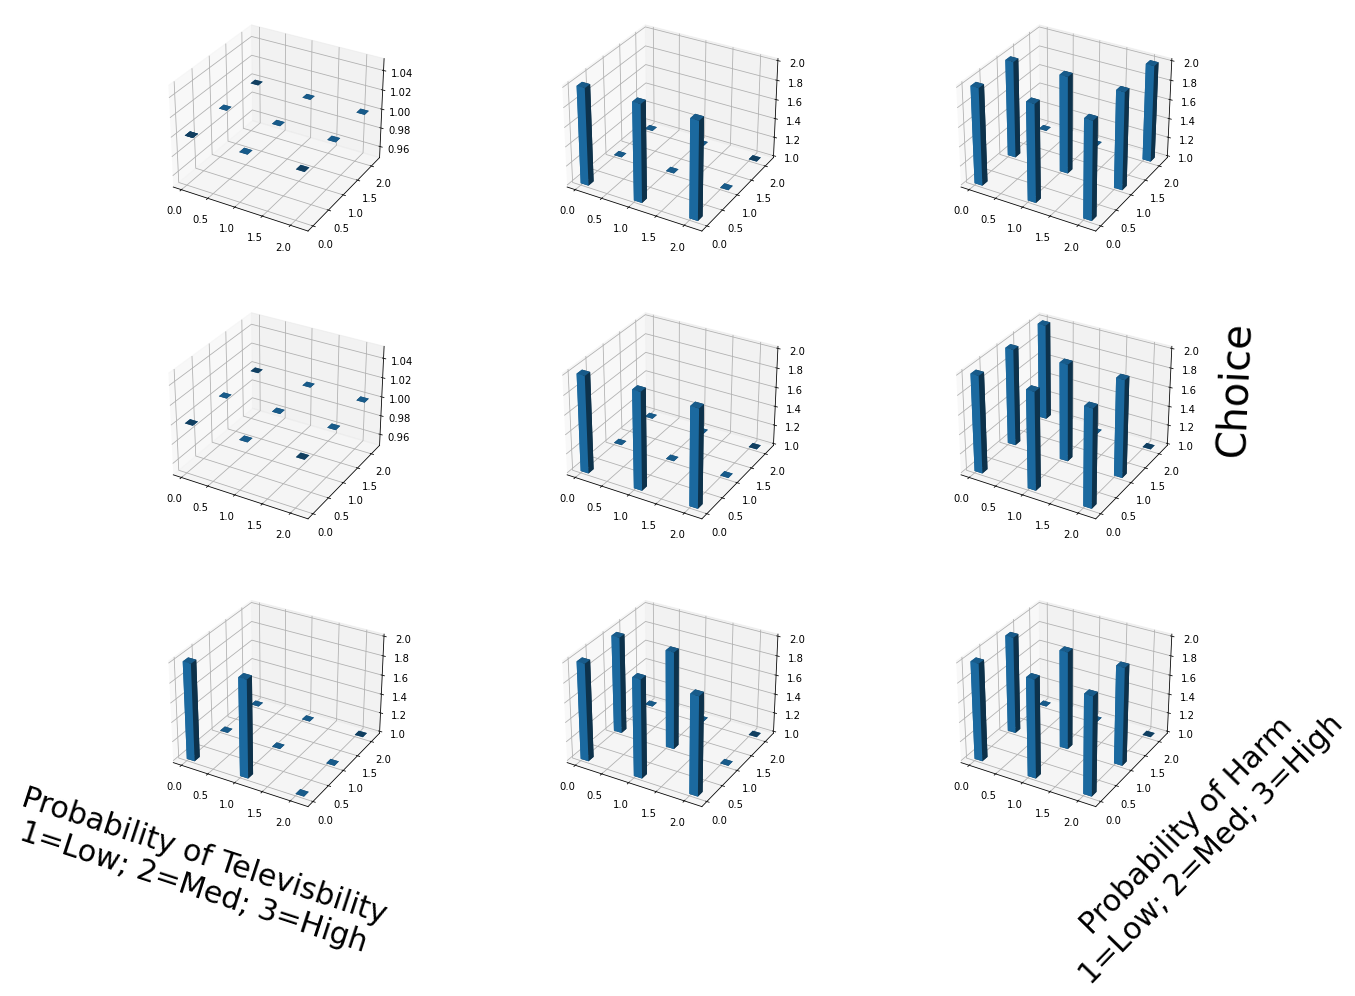

In [18]:
# Visual of what we're trying to model next
temp_df = plot_df[plot_df['participant']=='R_25Kjw8pvt3nUO7o'].reset_index(drop=True)
add_df = pd.DataFrame(['bx_analyst', 'R_25Kjw8pvt3nUO7o', 'med_low_low_low', 1, 'med', 'low', 'low', 'low', 1])
add_df = add_df.T
add_df.columns = list(temp_df)
temp_df = temp_df.append(add_df)

# Turn everything into numbers for plotting
temp_dict = {"low":0, "med":1, "high":2}
temp_df = temp_df.replace(temp_dict)

# Low televisibility first option
low_list = [col for col in list(temp_df['scenario'].unique()) if col.startswith("low_")]
low_df = temp_df[temp_df['scenario'].isin(low_list)].reset_index(drop=True)

# Med televisibility first option
med_list = [col for col in list(temp_df['scenario'].unique()) if col.startswith("med_")]
med_df = temp_df[temp_df['scenario'].isin(med_list)].reset_index(drop=True)

# High televisibility first option
high_list = [col for col in list(temp_df['scenario'].unique()) if col.startswith("high_")]
high_df = temp_df[temp_df['scenario'].isin(high_list)].reset_index(drop=True)

# Low subs
sub_1l = low_df[low_df['first_harm']==0]
sub_2l = low_df[low_df['first_harm']==1]
sub_3l = low_df[low_df['first_harm']==2]

# Med subs
sub_1m = med_df[med_df['first_harm']==0]
sub_2m = med_df[med_df['first_harm']==1]
sub_3m = med_df[med_df['first_harm']==2]

# High subs
sub_1h = high_df[high_df['first_harm']==0]
sub_2h = high_df[high_df['first_harm']==1]
sub_3h = high_df[high_df['first_harm']==2]

# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
fig = plt.figure(figsize=(20, 15))

# Low 
ax1 = fig.add_subplot(331, projection='3d')
ax1.bar3d(x='sec_tele', y='sec_harm', z='choice', dx=0.15, dy=0.15, dz=sub_1l['choice']-1, data=sub_1l)
ax2 = fig.add_subplot(332, projection='3d')
ax2.bar3d(x='sec_tele', y='sec_harm', z=[1,1,1,1,1,1,1,1,1], dx=0.15, dy=0.15, dz=sub_2l['choice']-1, data=sub_2l)
ax3 = fig.add_subplot(333, projection='3d')
ax3.bar3d(x='sec_tele', y='sec_harm', z=[1,1,1,1,1,1,1,1,1], dx=0.15, dy=0.15, dz=sub_3l['choice']-1, data=sub_3l)

# Med
ax4 = fig.add_subplot(334, projection='3d')
ax4.bar3d(x='sec_tele', y='sec_harm', z=[1,1,1,1,1,1,1,1,1], dx=0.15, dy=0.15, dz=sub_1m['choice']-1, data=sub_1m)
ax5 = fig.add_subplot(335, projection='3d')
ax5.bar3d(x='sec_tele', y='sec_harm', z=[1,1,1,1,1,1,1,1,1], dx=0.15, dy=0.15, dz=sub_2m['choice']-1, data=sub_2m)
ax6 = fig.add_subplot(336, projection='3d')
ax6.bar3d(x='sec_tele', y='sec_harm', z=[1,1,1,1,1,1,1,1,1], dx=0.15, dy=0.15, dz=sub_3m['choice']-1, data=sub_3m)
ax6.set_zlabel("Choice", fontsize=40, labelpad=20)

# High
ax7 = fig.add_subplot(337, projection='3d')
ax7.bar3d(x='sec_tele', y='sec_harm', z=[1,1,1,1,1,1,1,1,1], dx=0.15, dy=0.15, dz=sub_1h['choice']-1, data=sub_1h)
ax7.set_xlabel("Probability of Televisbility\n1=Low; 2=Med; 3=High", fontsize=30, labelpad=40)
ax8 = fig.add_subplot(338, projection='3d')
ax8.bar3d(x='sec_tele', y='sec_harm', z=[1,1,1,1,1,1,1,1,1], dx=0.15, dy=0.15, dz=sub_2h['choice']-1, data=sub_2h)
ax9 = fig.add_subplot(339, projection='3d')
ax9.bar3d(x='sec_tele', y='sec_harm', z=[1,1,1,1,1,1,1,1,1], dx=0.15, dy=0.15, dz=sub_3h['choice']-1, data=sub_3h)
ax9.set_ylabel("Probability of Harm\n1=Low; 2=Med; 3=High", fontsize=30, labelpad=40)

plt.ylim=(0.9, 2.1) 
plt.show()

In [19]:
def plot_indiv(df, part=None):
    # Setup df for participant
    temp_df = df[df['participant']==part].reset_index(drop=True)
    
    # OLS model at individual level
    reg_res = smf.ols('choice ~ source + first_tele + first_harm + sec_tele + sec_harm', data=temp_df).fit()
    results_summary = reg_res.summary()
    results_as_html = results_summary.tables[1].as_html()
    results = pd.read_html(results_as_html, header=0, index_col=0)[0]
    results = results.unstack().to_frame().T
    results['participant']=part
    results['source'] = temp_df['source'].unique()
    results['rsquared'] = reg_res.rsquared
    
    # Plot it
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 7.5), sharex=True, sharey=True)
    sns.barplot(ax=ax[0, 0], y='first_tele', x='choice', data=temp_df, hue='source', color='k', errwidth=.5, capsize=.2)
    sns.barplot(ax=ax[0, 1], y='first_harm', x='choice', data=temp_df, hue='source', color='k', errwidth=.5, capsize=.2)
    sns.barplot(ax=ax[1, 0], y='sec_tele', x='choice', data=temp_df, hue='source', color='k', errwidth=.5, capsize=.2)
    sns.barplot(ax=ax[1, 1], y='sec_harm', x='choice', data=temp_df, hue='source', color='k', errwidth=.5, capsize=.2)
    fig.supylabel("Probability Level", fontsize=24)
    fig.supxlabel("1=Allow, 2=Don't Allow", fontsize=24)
    plt.yticks(fontsize=16)
    plt.xlim(0.9, 2.1)
    fig.suptitle(f"{part}", fontsize=24)
    plt.savefig(f"../figures/individual_plots/indiv_plot_{part}.png", bbox_inches='tight')
    plt.show()
    print("\n")
    
    return results

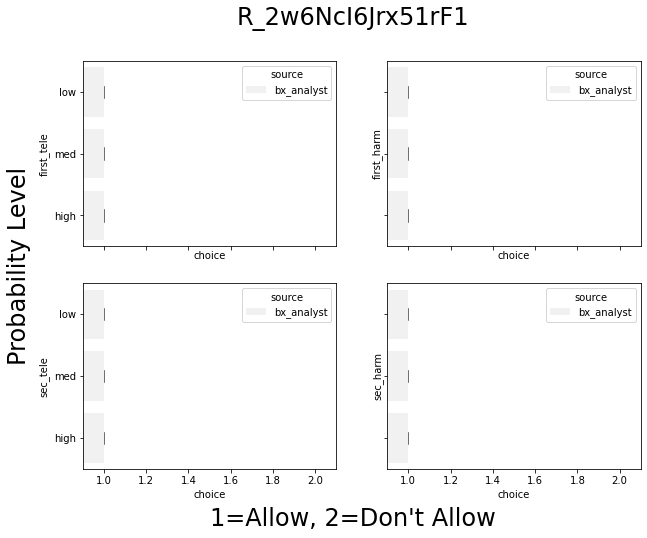

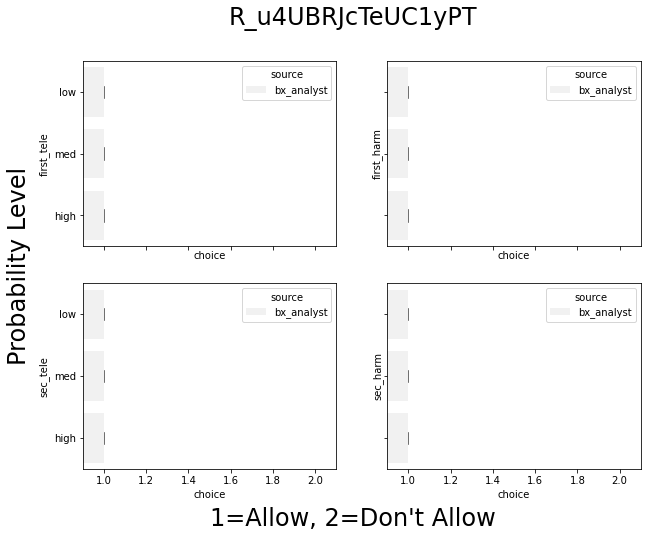

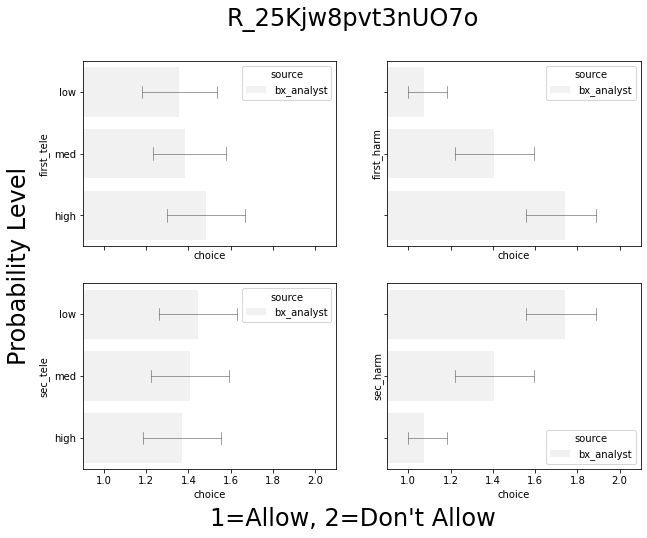

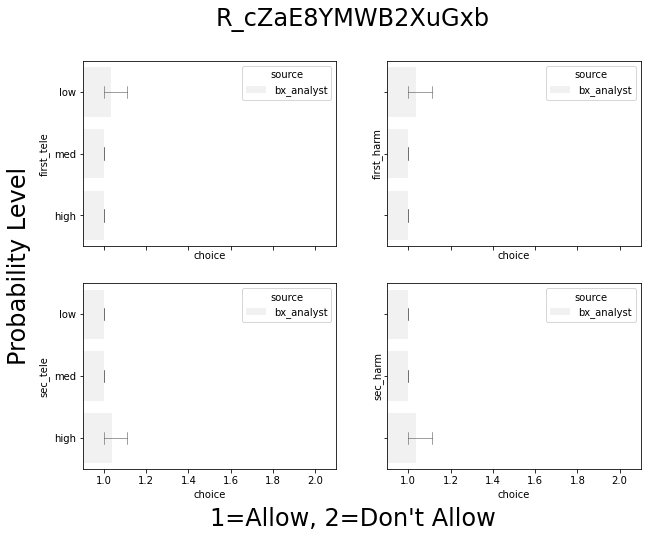

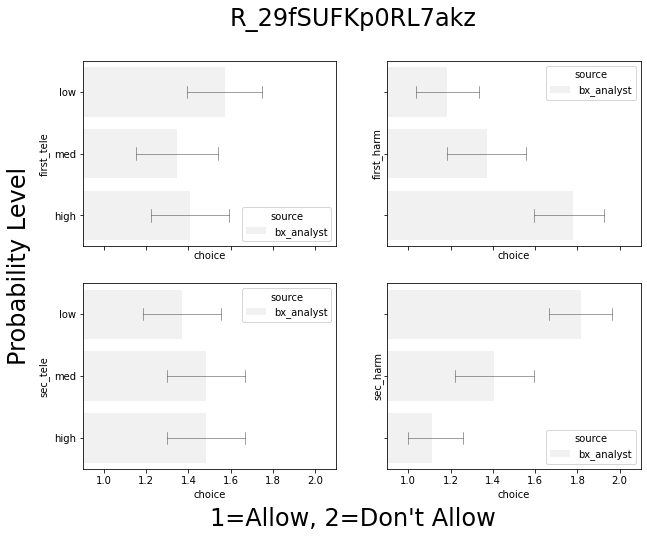

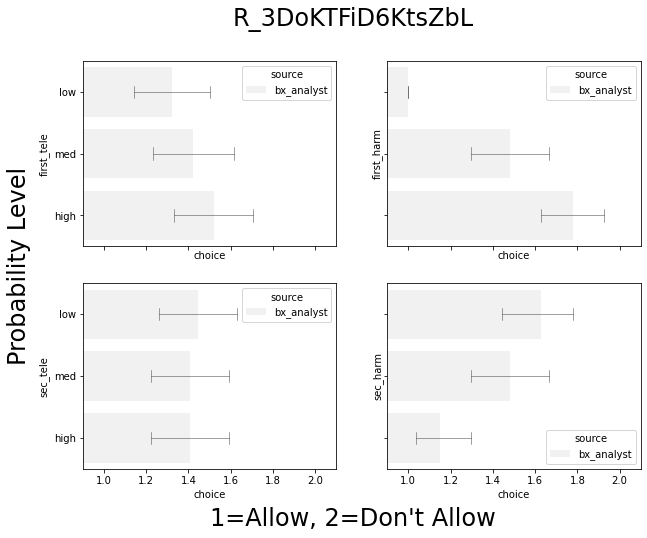

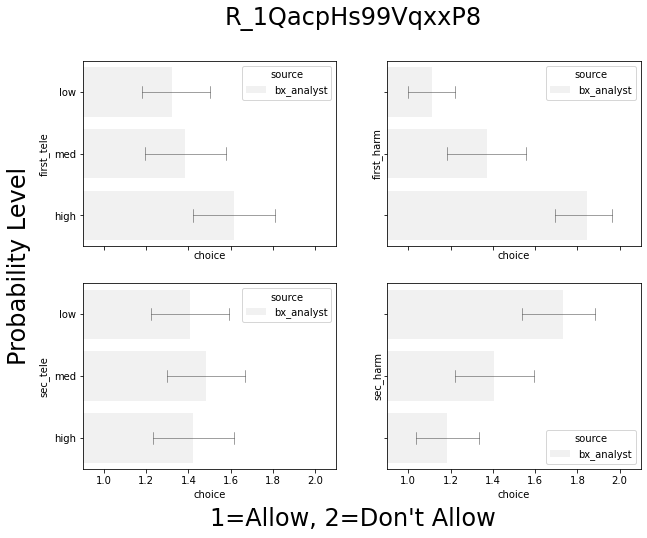

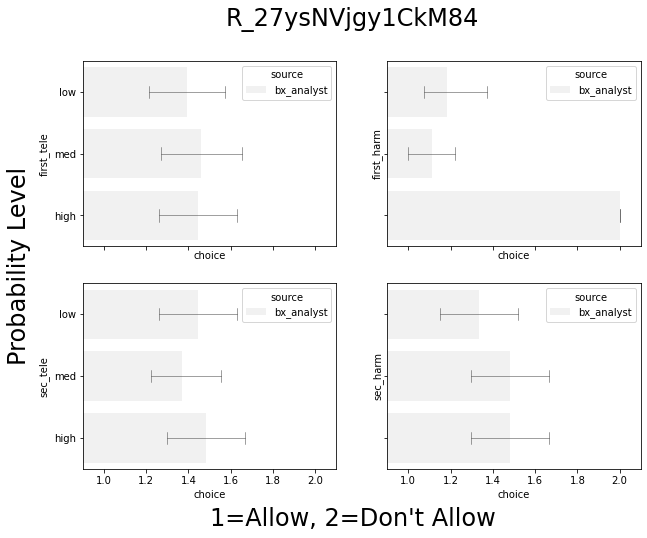

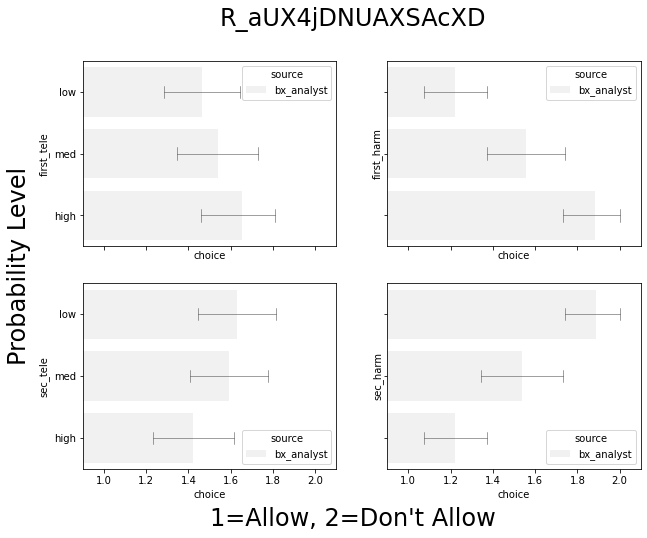

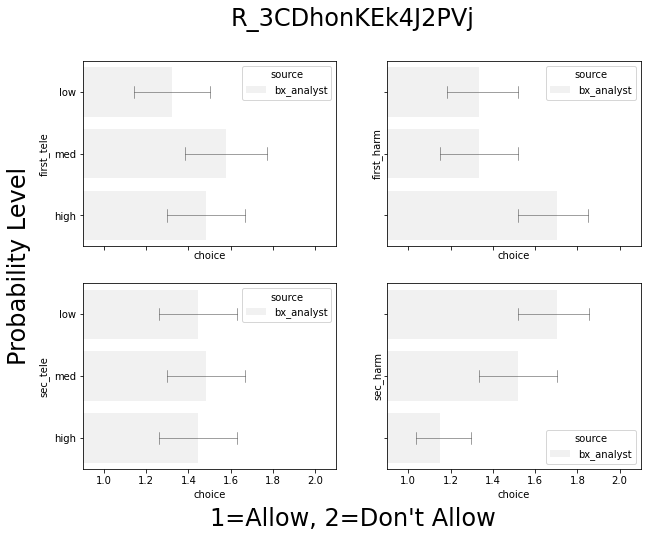

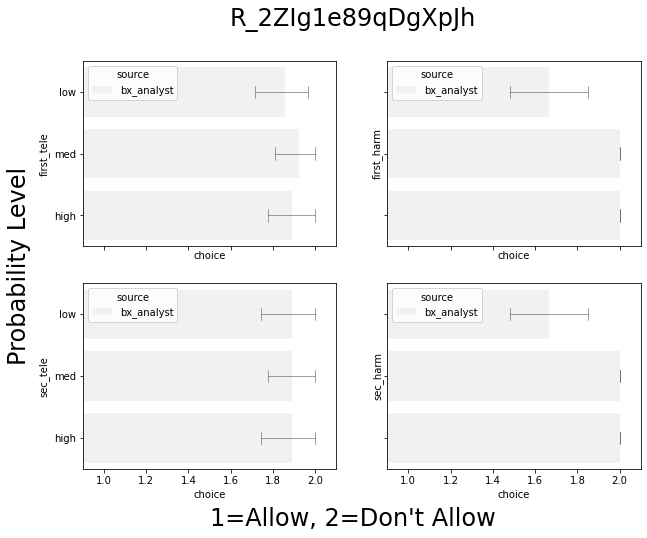

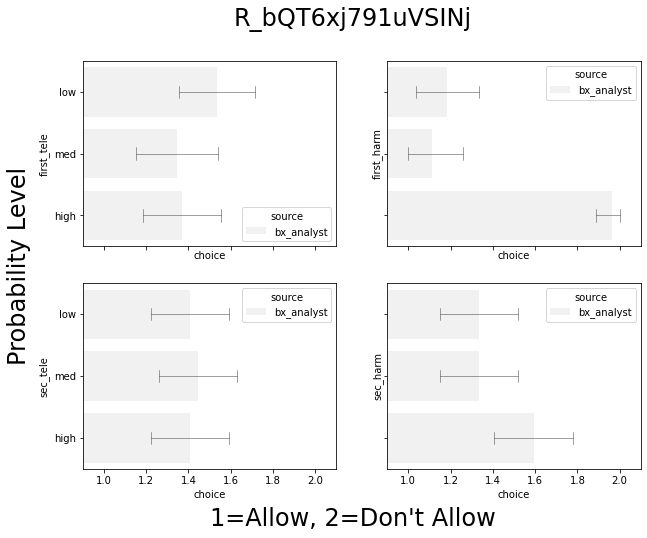

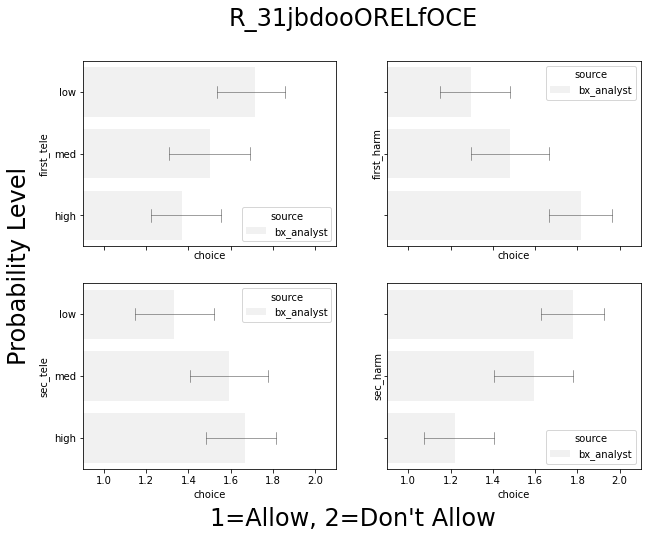

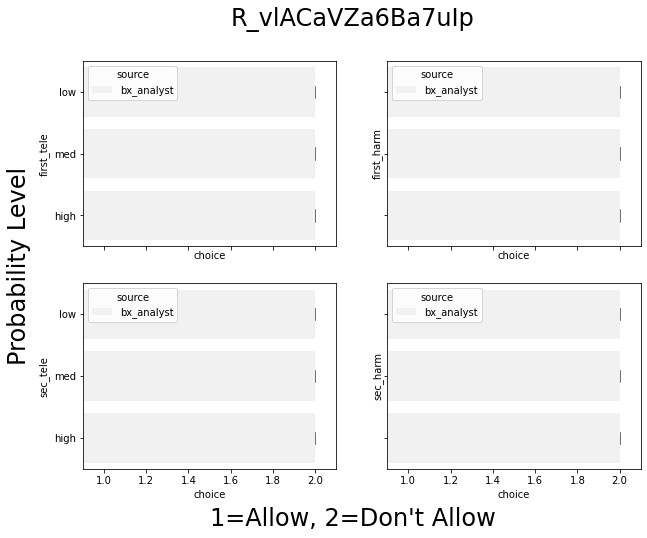

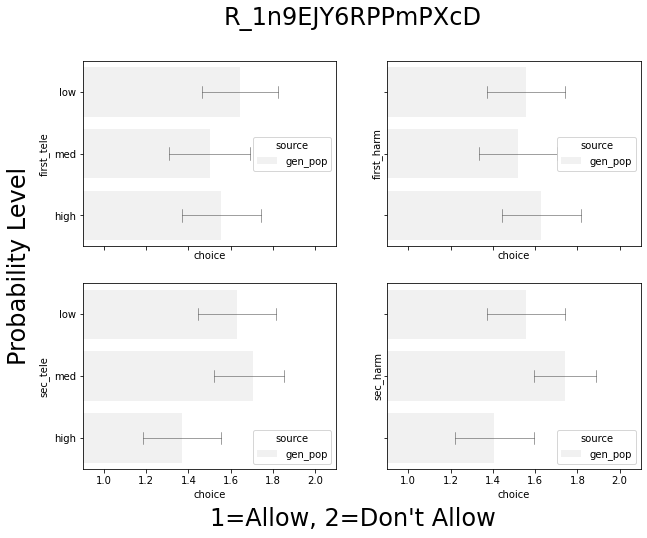

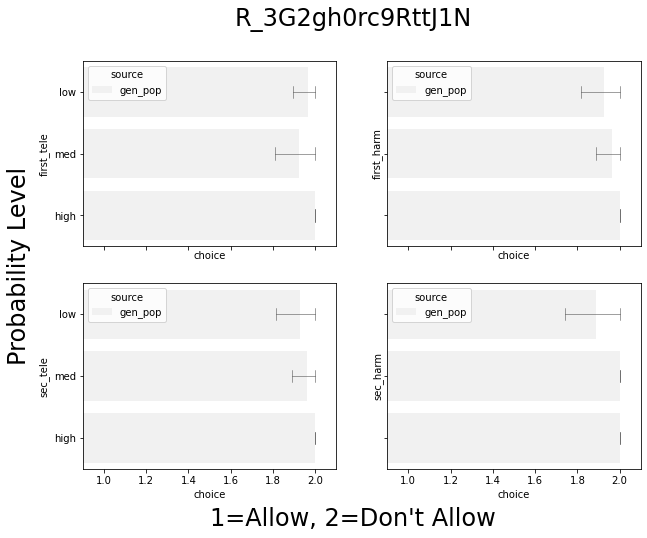

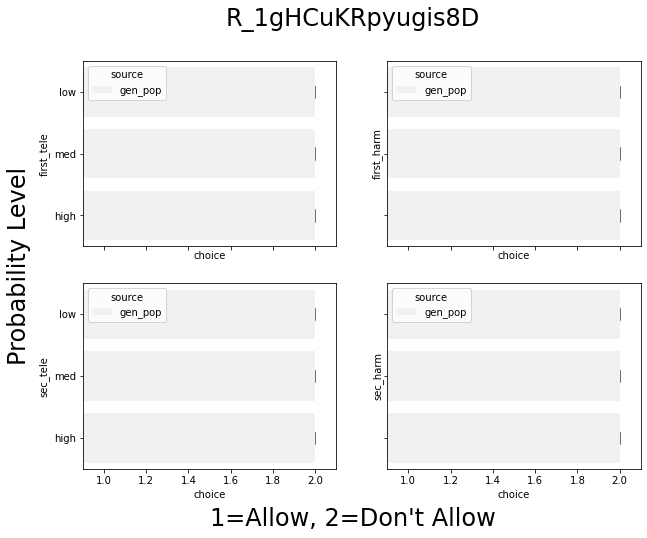

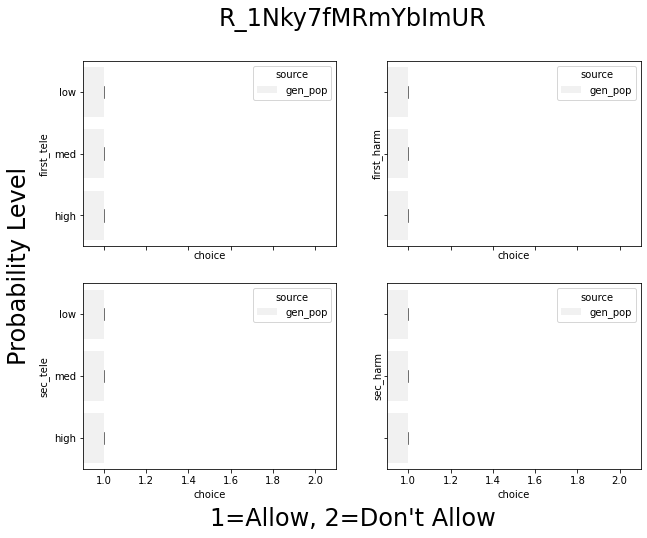

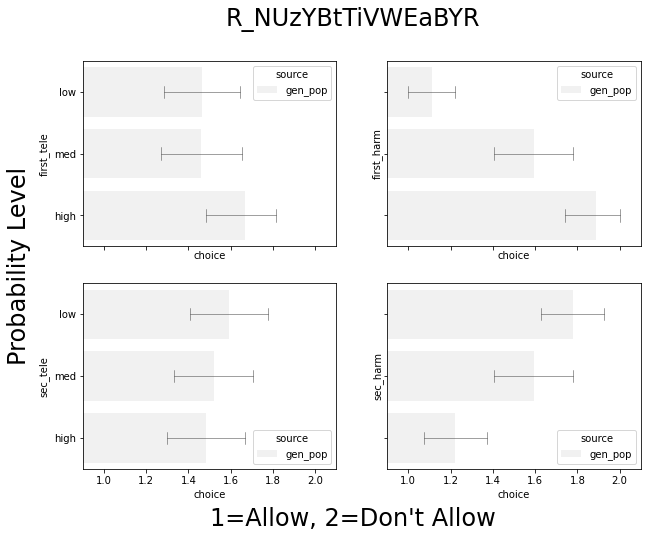

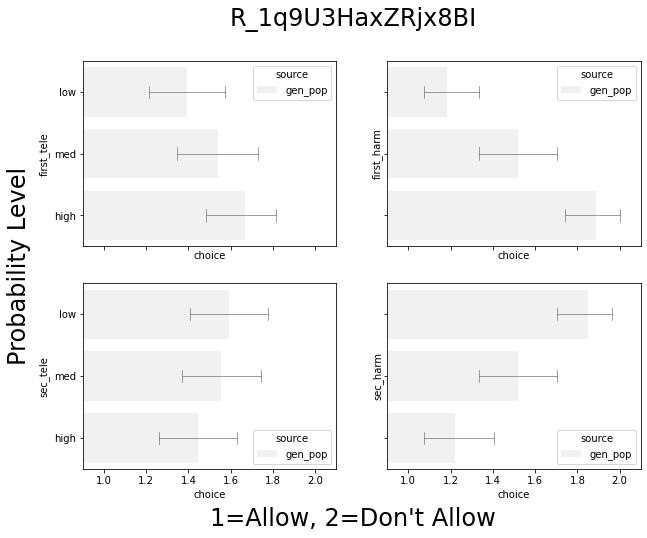

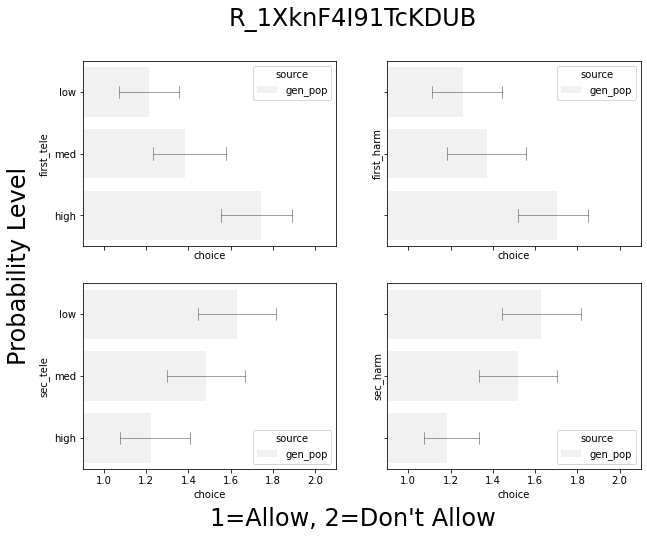

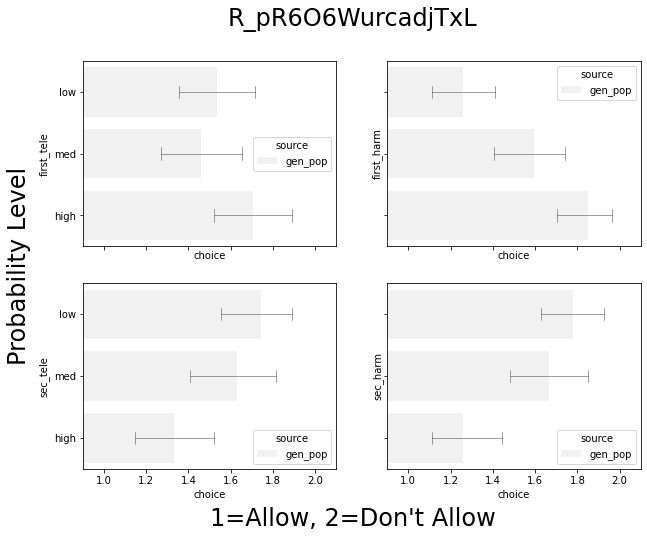

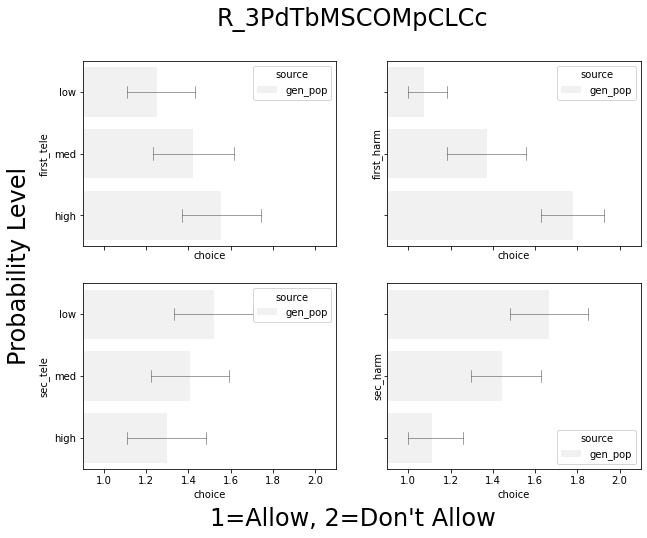

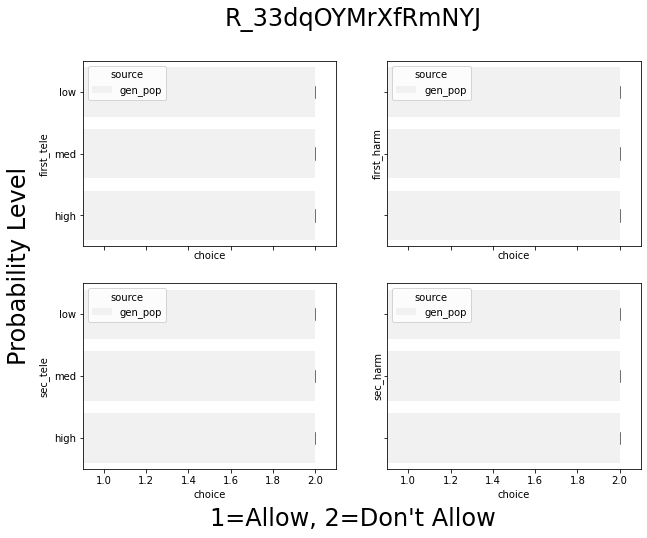

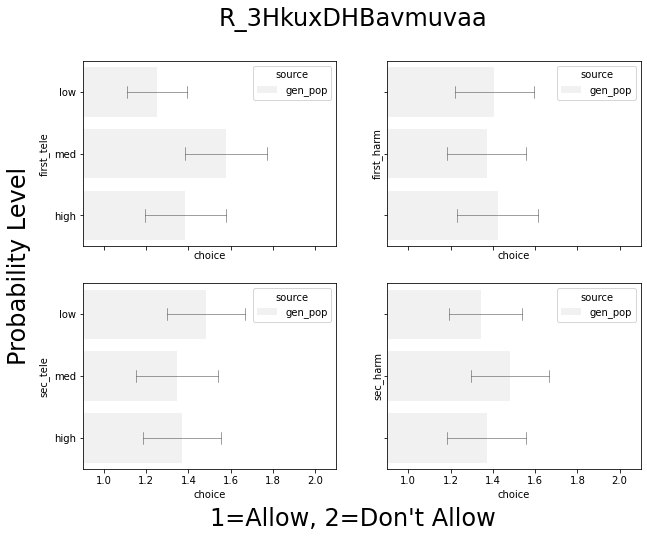

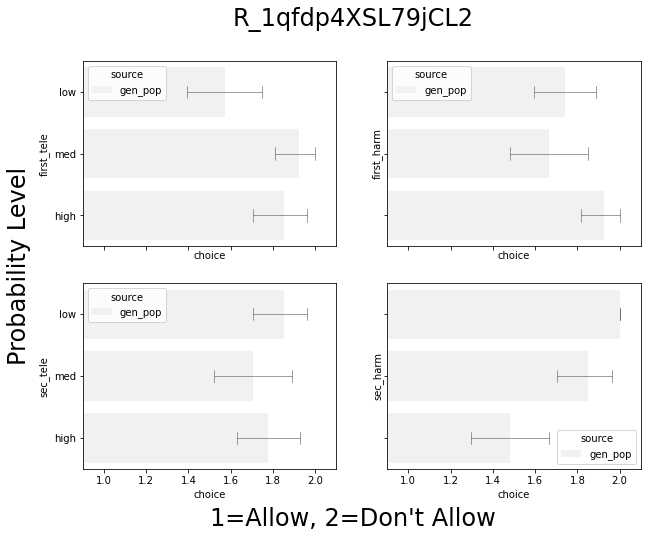

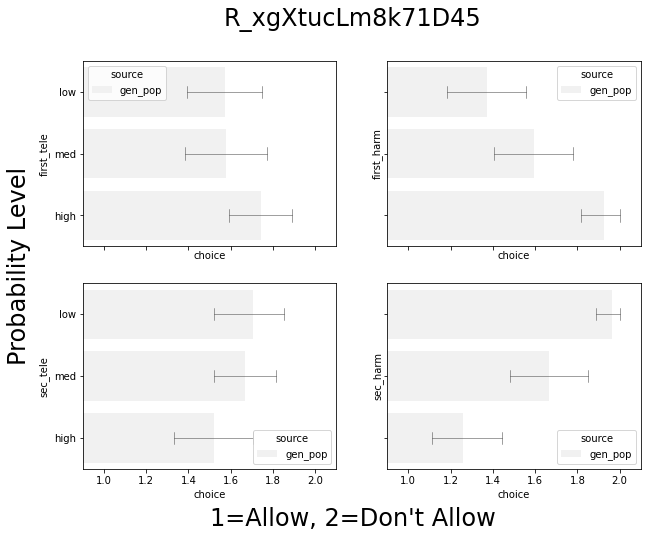

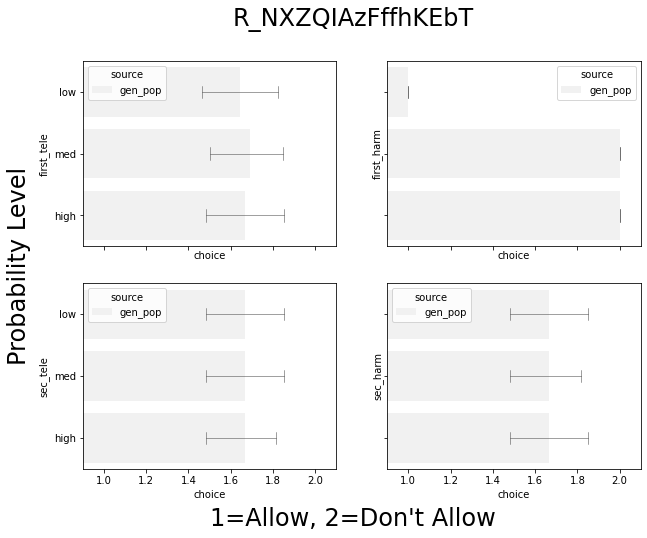

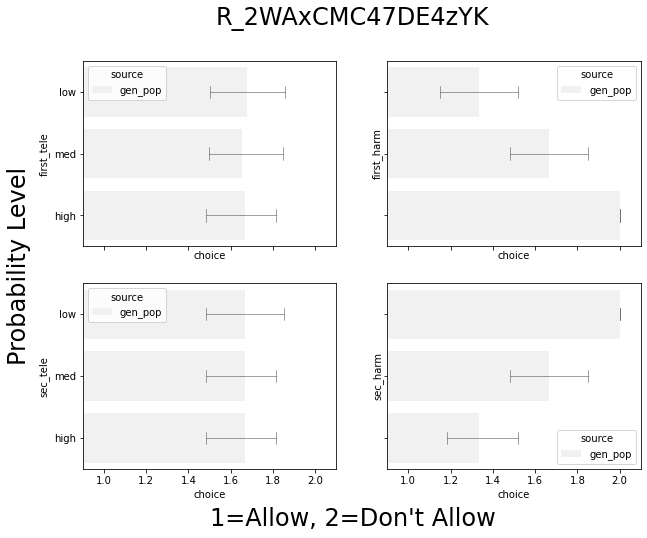

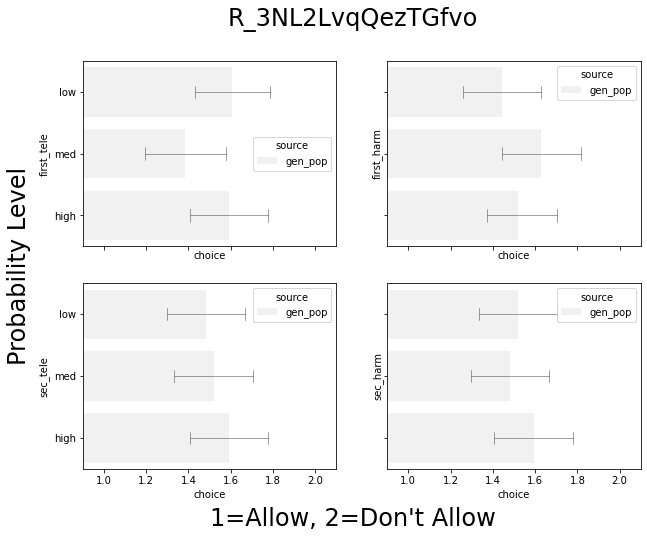

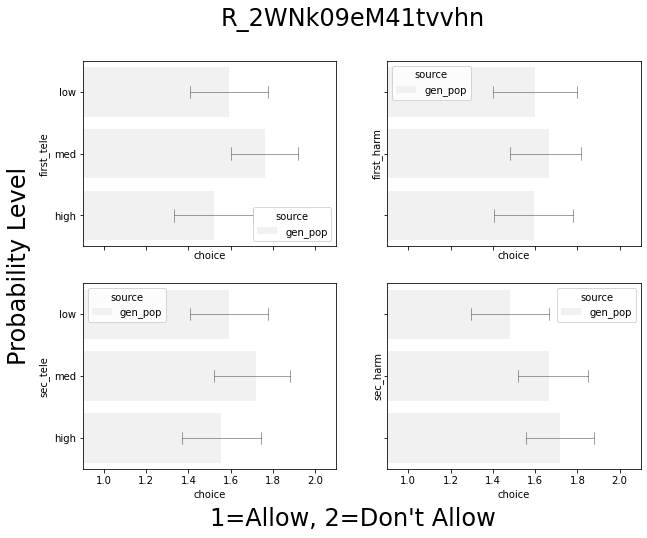

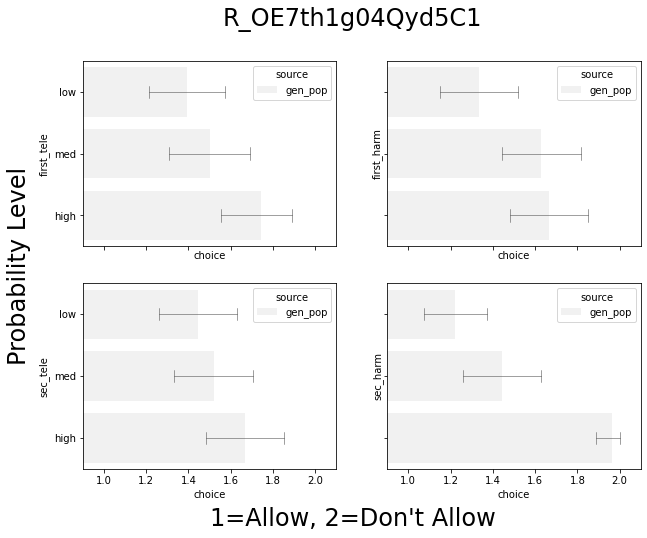

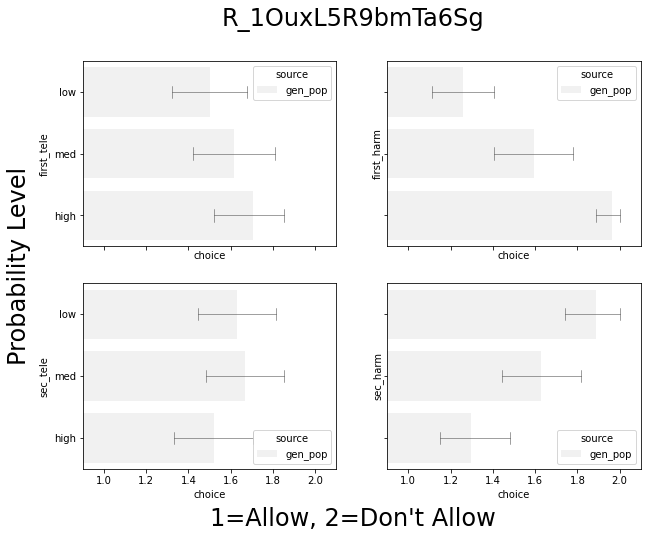

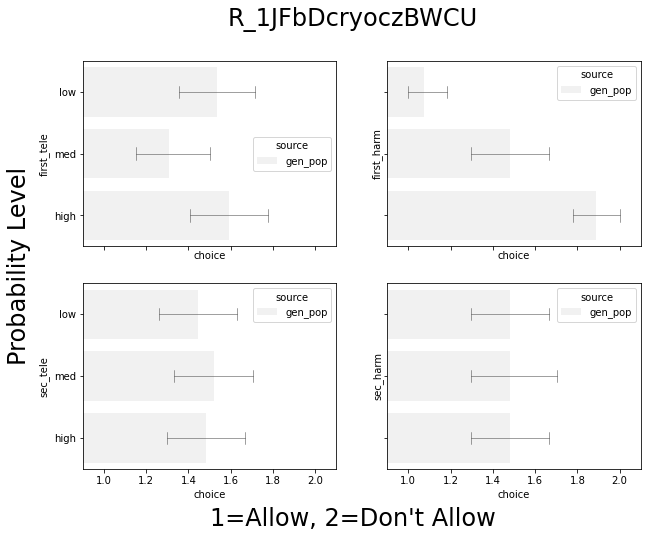

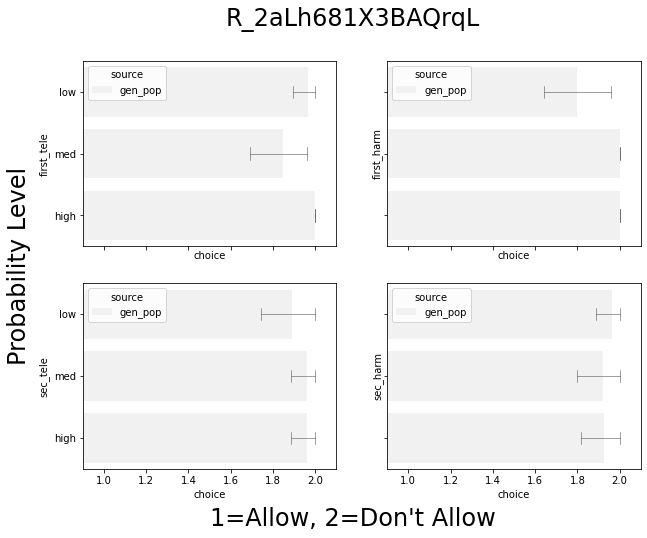

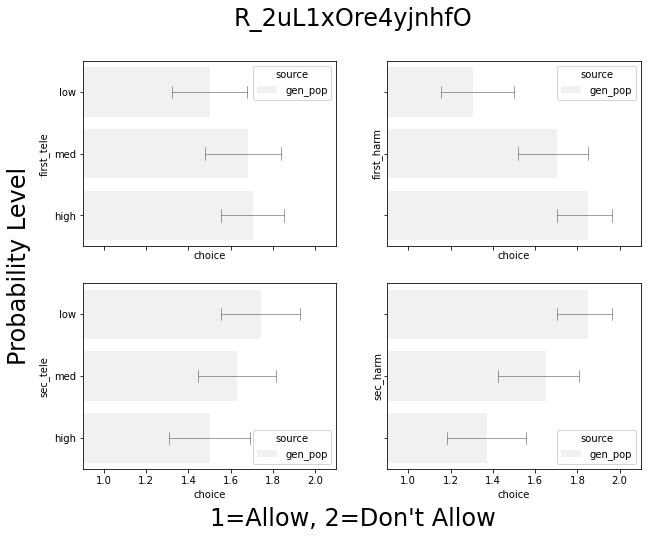

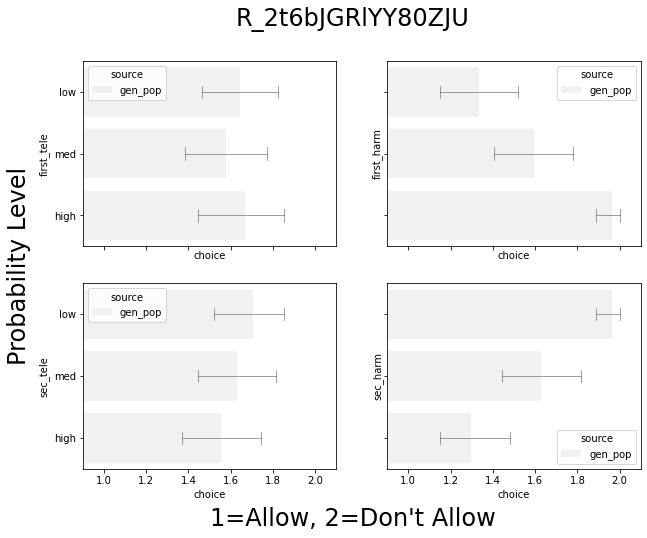

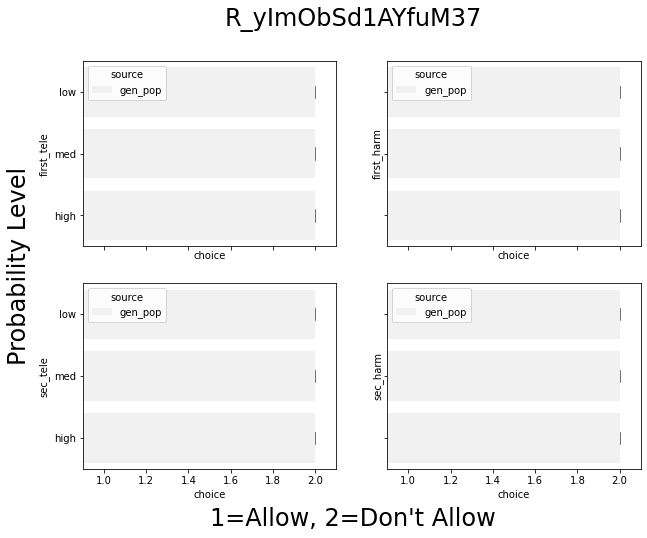

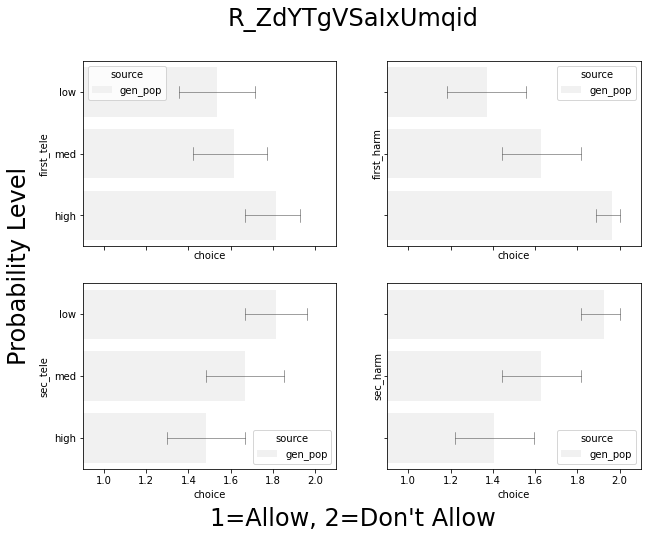

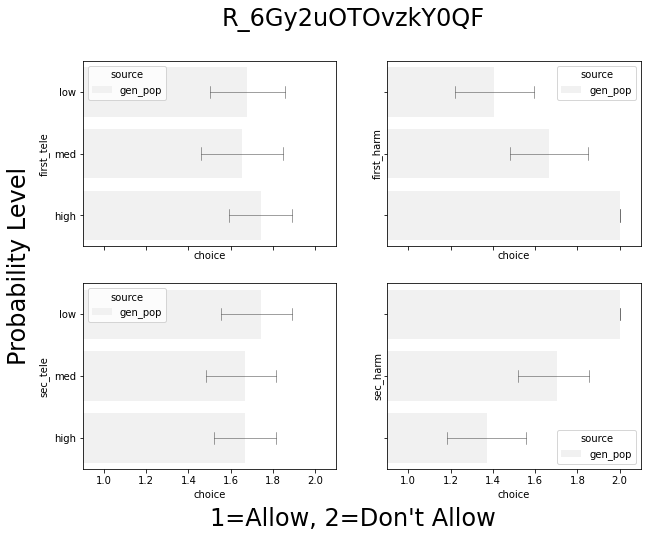

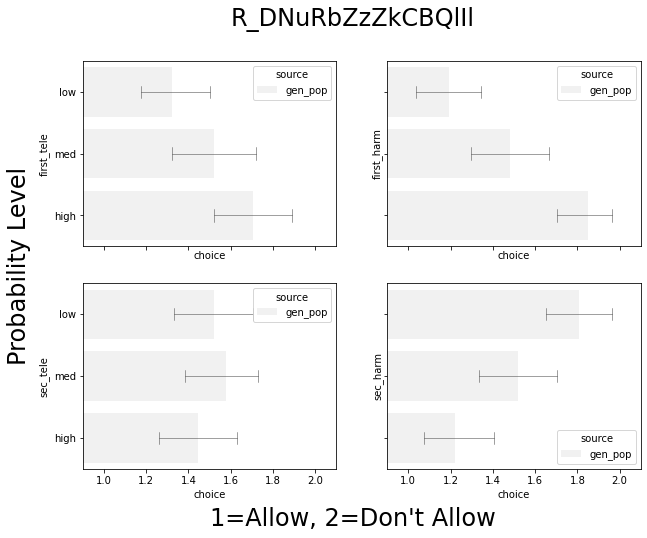

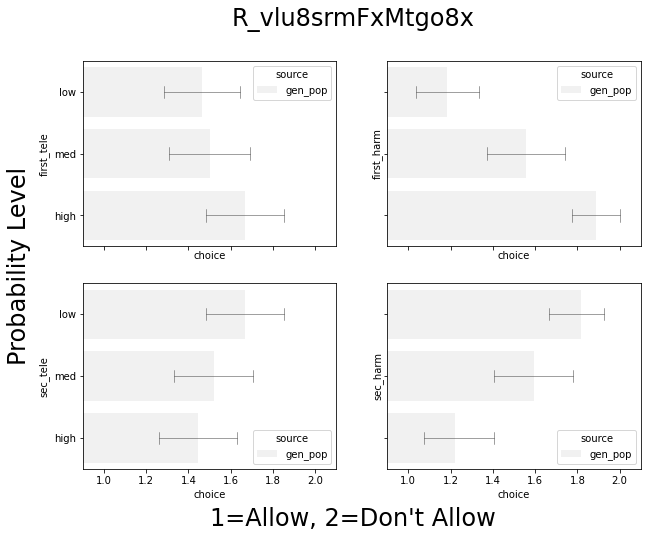

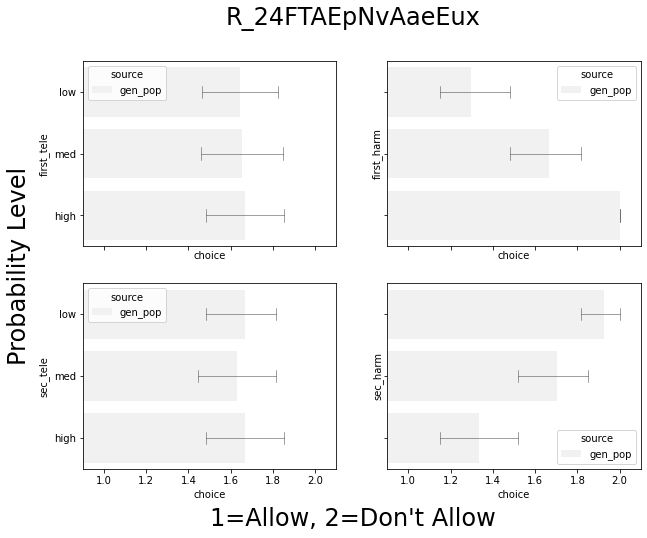

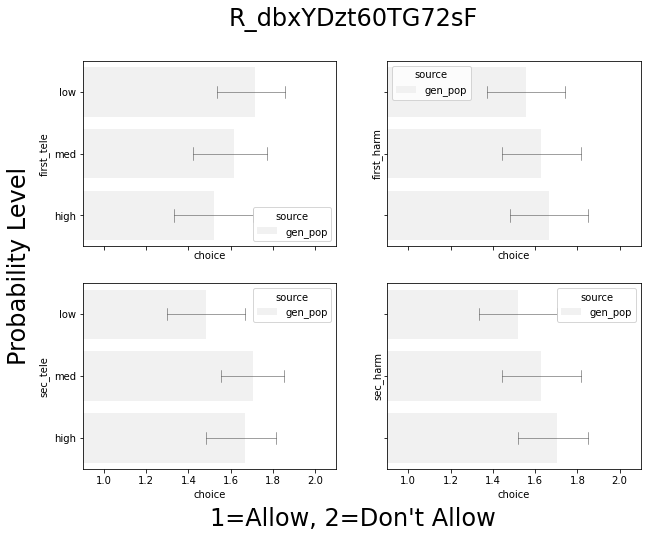

In [20]:
# Calculate OLS model for each participant and show their results along the main IVs
all_summary = pd.DataFrame()
for i in num_df['participant'].unique():
    summary = plot_indiv(df=plot_df, part=i)
    all_summary = all_summary.append(summary)

In [21]:
# Function above returns a tuple for the column headers. Let's clean it up
new_cols = []

for item in list(all_summary):
    val = str(item)
    val = val[(val.find("'")+1):(val.find(")")-1)]
    val = val.replace("', '", "_")
    val = val.replace("[T.", "_")
    val = val.replace("]", "")
    val = val.replace("[", "")
    val = val.replace(" ", "_")
    val = val.lower()
    val = val.strip()
    new_cols.append(val)

all_summary.columns = new_cols
all_summary = all_summary.reset_index(drop=True)
all_summary[::12]

coef_intercept  coef_first_tele_low  coef_first_tele_med  \
0           1.0000        -5.551000e-17        -2.220000e-16   
12          1.4900         3.511000e-01         1.219000e-01   
24          1.3319        -1.334000e-01         1.981000e-01   
36          1.5947        -2.760000e-02        -8.560000e-02   

    coef_first_harm_low  coef_first_harm_med  coef_sec_tele_low  \
0         -2.776000e-17         4.163000e-17       4.857000e-17   
12        -5.270000e-01        -3.333000e-01      -3.418000e-01   
24         1.500000e-03        -4.780000e-02       1.234000e-01   
36        -6.318000e-01        -3.704000e-01       1.460000e-01   

    coef_sec_tele_med  coef_sec_harm_low  coef_sec_harm_med  \
0        7.633000e-17      -6.245000e-17       3.469000e-17   
12      -7.410000e-02       5.471000e-01       3.704000e-01   
24      -2.620000e-02      -1.400000e-02       1.111000e-01   
36       7.410000e-02       6.645000e-01       3.333000e-01   

    std_err_intercept  std_err_first_tele_low  std_err_first_tele_med  \
0        5.310000e-17            4.090000e-17            4.180000e-17   
12       1.160000e-01            9.400000e-02            9.600000e-02   
24       1.650000e-01            1.340000e-01            1.360000e-01   
36       1.050000e-01            8.500000e-02            8.600000e-02   

    std_err_first_harm_low  std_err_first_harm_med  std_err_sec_tele_low  \
0             4.130000e-17            4.130000e-17          4.130000e-17   
12            9.500000e-02            9.500000e-02          9.500000e-02   
24            1.350000e-01            1.350000e-01          1.340000e-01   
36            8.500000e-02            8.500000e-02          8.500000e-02   

    std_err_sec_tele_med  std_err_sec_harm_low  std_err_sec_harm_med  \
0           4.130000e-17          4.130000e-17          4.130000e-17   
12          9.500000e-02          9.500000e-02          9.500000e-02   
24          1.350000e-01          1.350000e-01          1.340000e-01   
36          8.500000e-02          8.500000e-02          8.500000e-02   

     t_intercept  t_first_tele_low  t_first_tele_med  t_first_harm_low  \
0   1.880000e+16            -1.356            -5.317            -0.671   
12  1.283800e+01             3.738             1.273            -5.560   
24  8.078000e+00            -0.996             1.453             0.011   
36  1.524500e+01            -0.326            -0.993            -7.395   

    t_first_harm_med  t_sec_tele_low  t_sec_tele_med  t_sec_harm_low  \
0              1.008           1.175           1.848          -1.511   
12            -3.519          -3.606          -0.782           5.771   
24            -0.354           0.923          -0.194          -0.103   
36            -4.338           1.709           0.868           7.778   

    t_sec_harm_med  p>|t|_intercept  p>|t|_first_tele_low  \
0            0.840              0.0                 0.179   
12           3.910              0.0                 0.000   
24           0.831              0.0                 0.323   
36           3.904              0.0                 0.745   

    p>|t|_first_tele_med  p>|t|_first_harm_low  p>|t|_first_harm_med  \
0                  0.000                 0.504                 0.317   
12                 0.207                 0.000                 0.001   
24                 0.151                 0.991                 0.724   
36                 0.324                 0.000                 0.000   

    p>|t|_sec_tele_low  p>|t|_sec_tele_med  p>|t|_sec_harm_low  \
0                0.244               0.069               0.135   
12               0.001               0.437               0.000   
24               0.359               0.846               0.918   
36               0.092               0.388               0.000   

    p>|t|_sec_harm_med  0.025_intercept  0.025_first_tele_low  \
0                0.404            1.000         -1.370000e-16   
12               0.000            1.259          1.640000e-01  

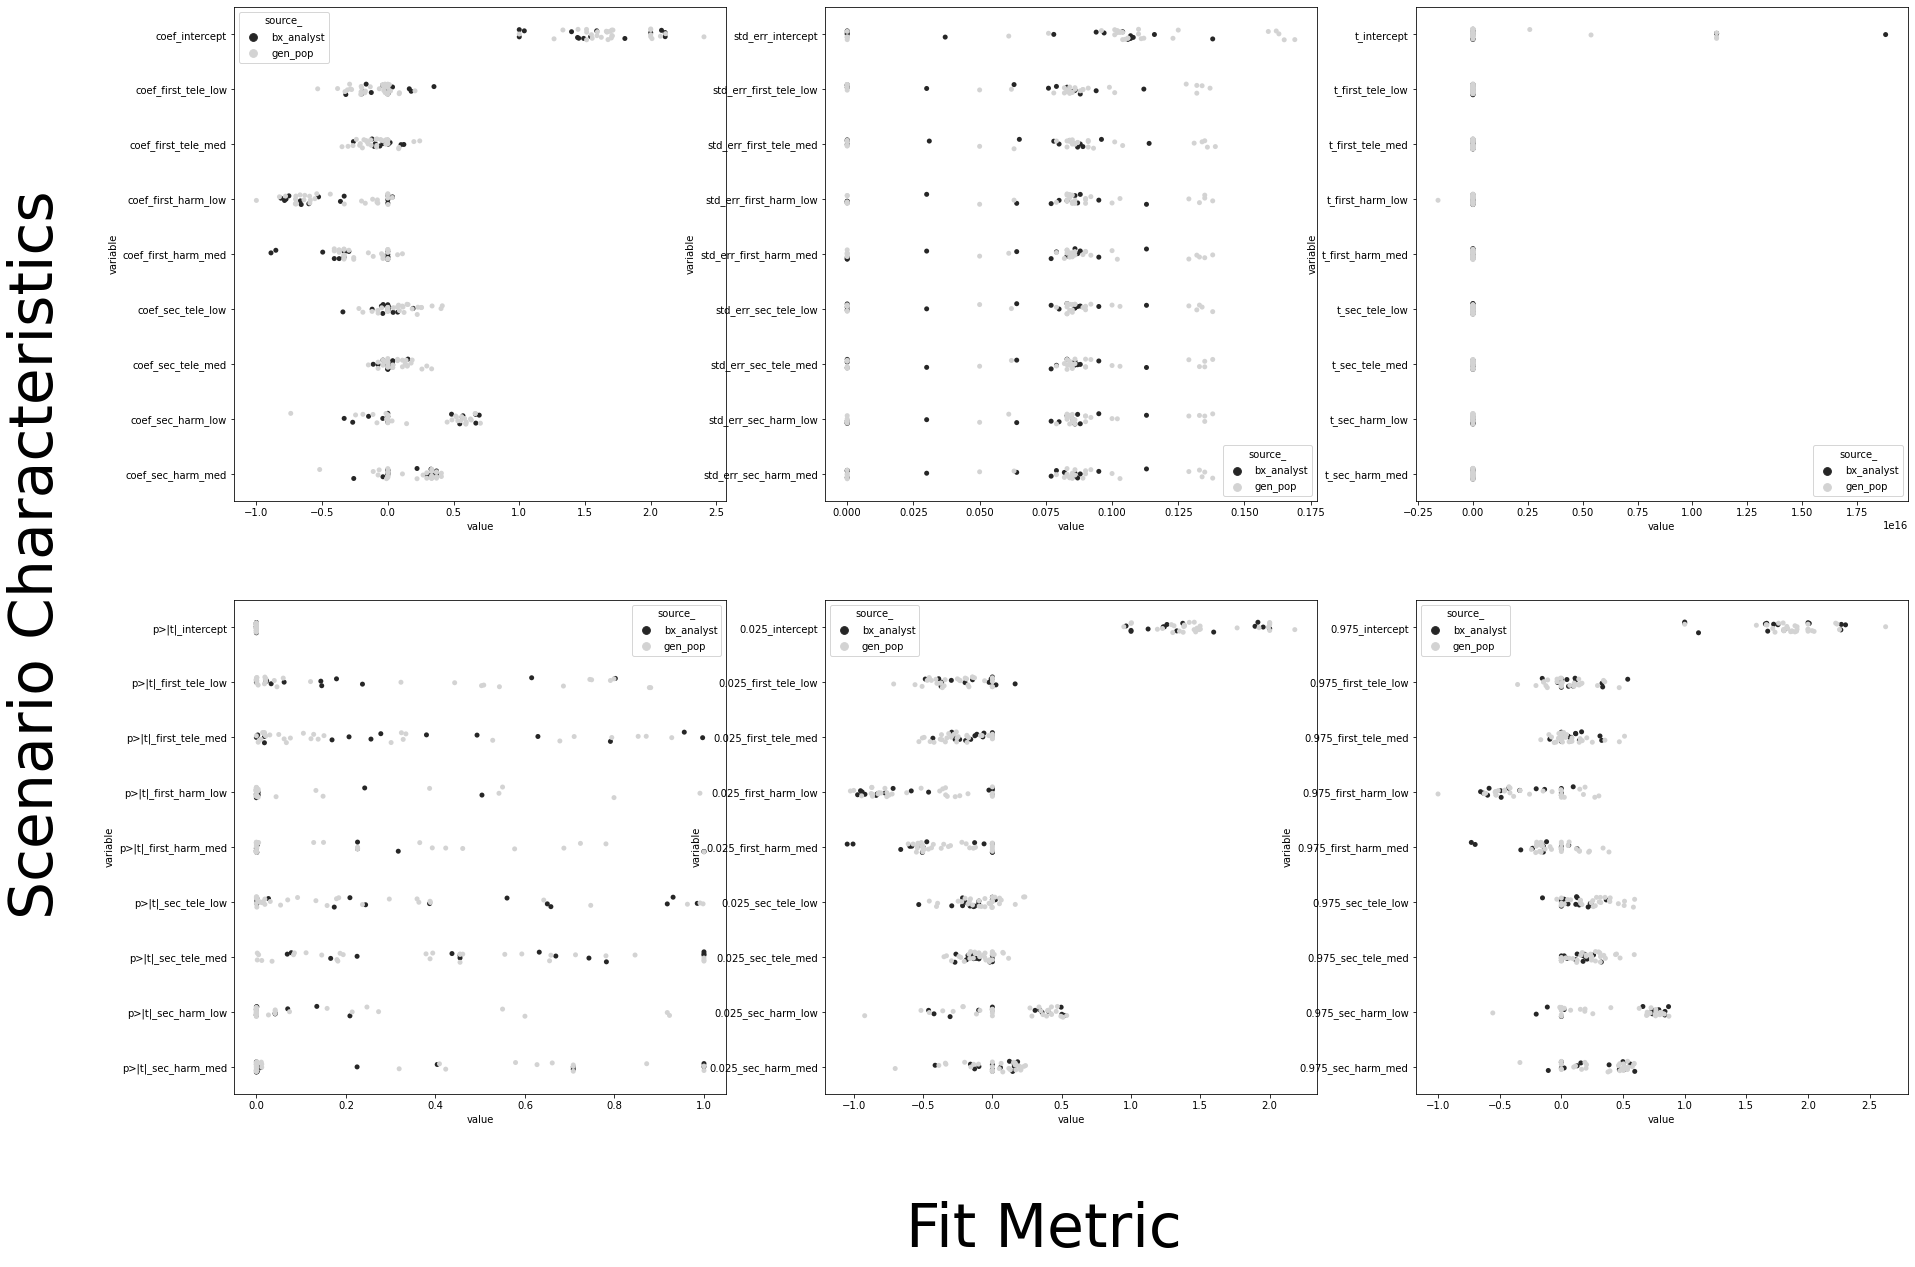

In [22]:
# Plot the different results
indiv_results = all_summary.melt(id_vars=['participant_', 'source_'])

# Get lists of variable values
coef = [val for val in indiv_results['variable'].unique() if val.startswith("coef")]
std_err = [val for val in indiv_results['variable'].unique() if val.startswith("std_err")]
t = [val for val in indiv_results['variable'].unique() if val.startswith("t_")]
p = [val for val in indiv_results['variable'].unique() if val.startswith("p>")]
o25 = [val for val in indiv_results['variable'].unique() if val.startswith("0.025")]
o975 = [val for val in indiv_results['variable'].unique() if val.startswith("0.975")]

# Choices by scenario and group
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(30,20))
sns.stripplot(ax=ax[0, 0], x='value', y='variable', 
              data=indiv_results[indiv_results['variable'].isin(coef)], 
            hue='source_', color='lightgray')
sns.stripplot(ax=ax[0, 1], x='value', y='variable', 
              data=indiv_results[indiv_results['variable'].isin(std_err)], 
            hue='source_', color='lightgray')
sns.stripplot(ax=ax[0, 2], x='value', y='variable',
              data=indiv_results[indiv_results['variable'].isin(t)],
            hue='source_', color='lightgray')
sns.stripplot(ax=ax[1, 0], x='value', y='variable',
              data=indiv_results[indiv_results['variable'].isin(p)],
            hue='source_', color='lightgray')
sns.stripplot(ax=ax[1, 1], x='value', y='variable',
              data=indiv_results[indiv_results['variable'].isin(o25)],
            hue='source_', color='lightgray')
sns.stripplot(ax=ax[1, 2], x='value', y='variable',
              data=indiv_results[indiv_results['variable'].isin(o975)],
            hue='source_', color='lightgray')
fig.supxlabel("Fit Metric", fontsize=60)
fig.supylabel("Scenario Characteristics", fontsize=60)
plt.show()

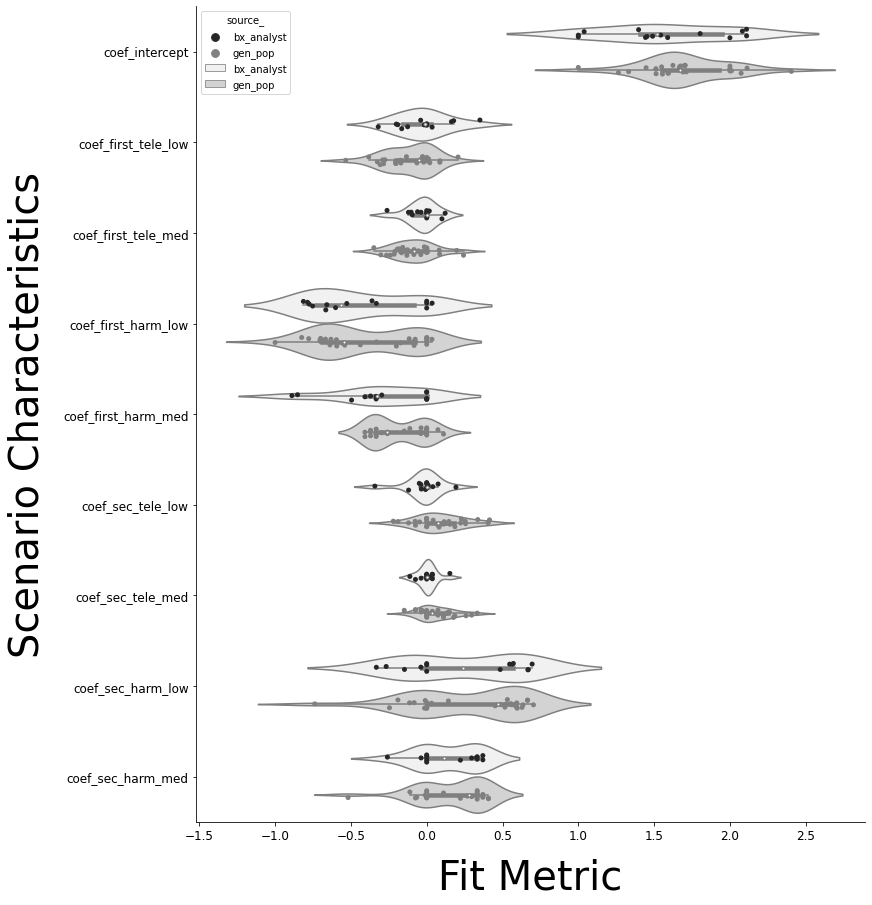

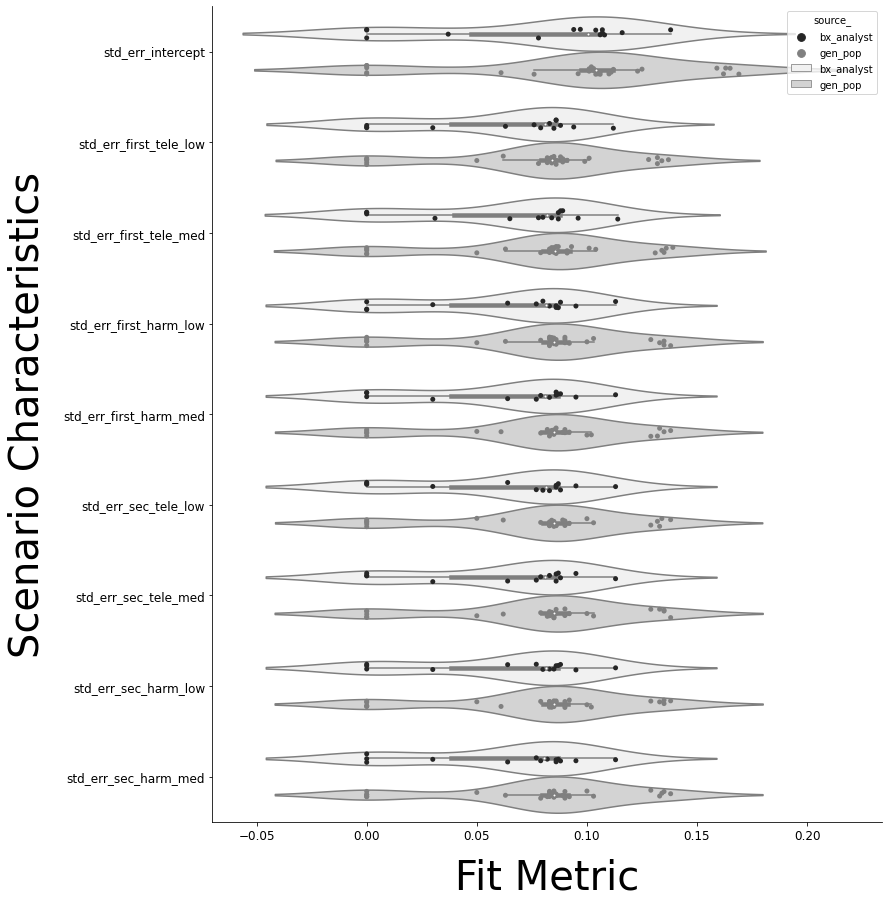

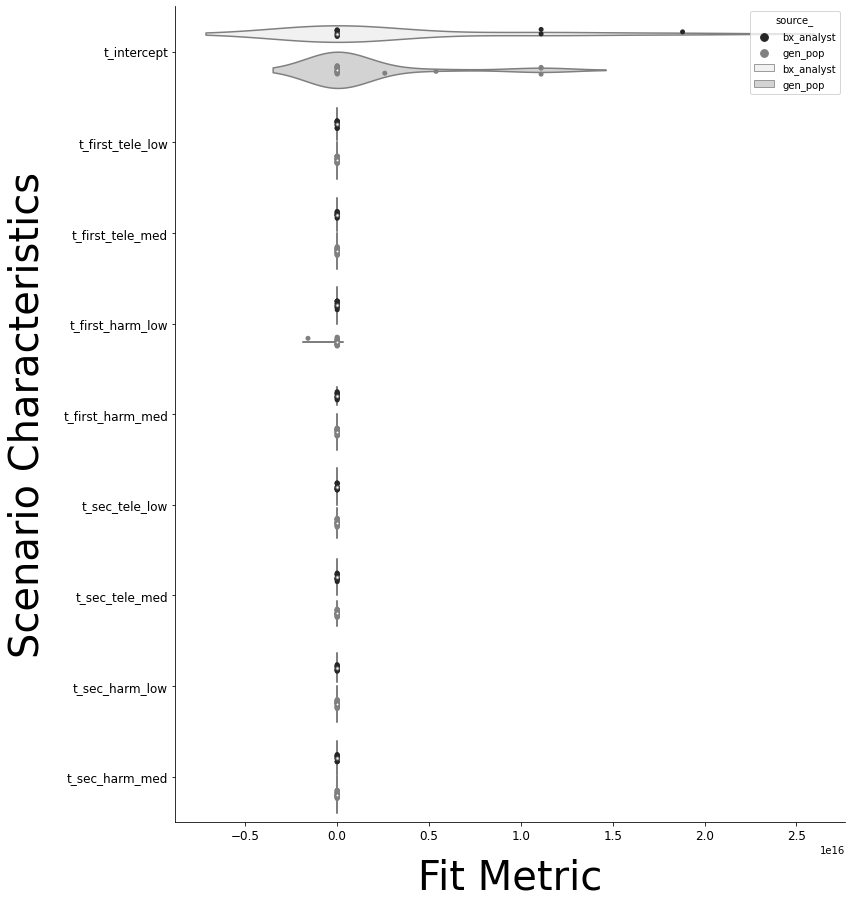

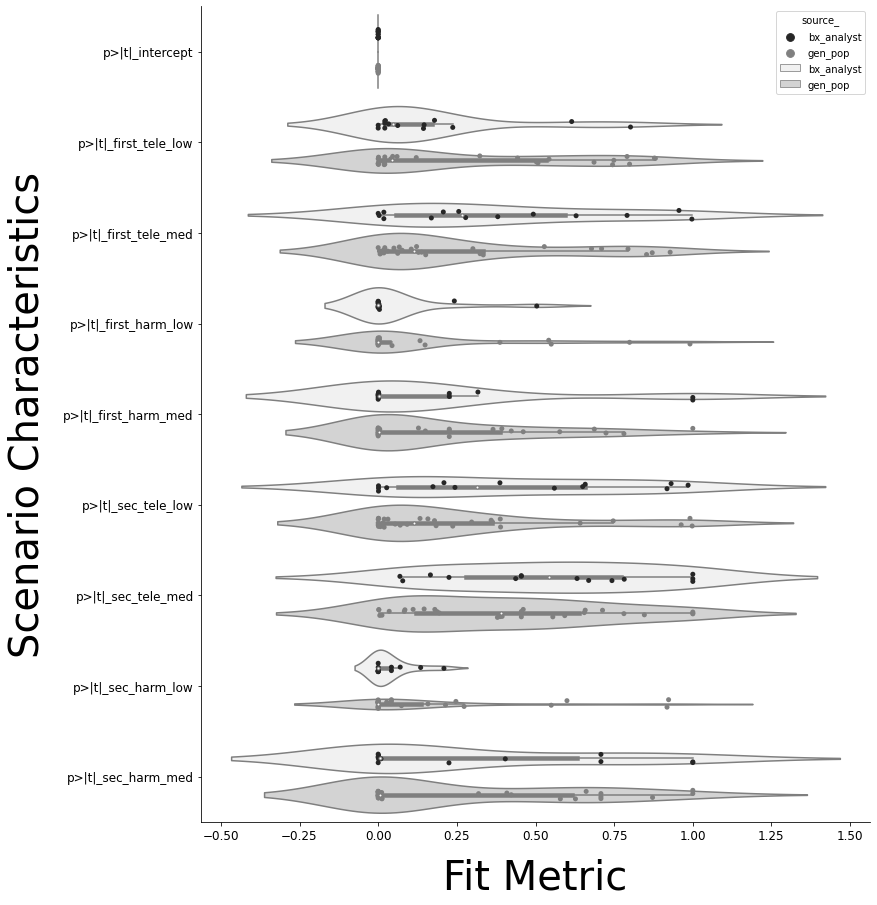

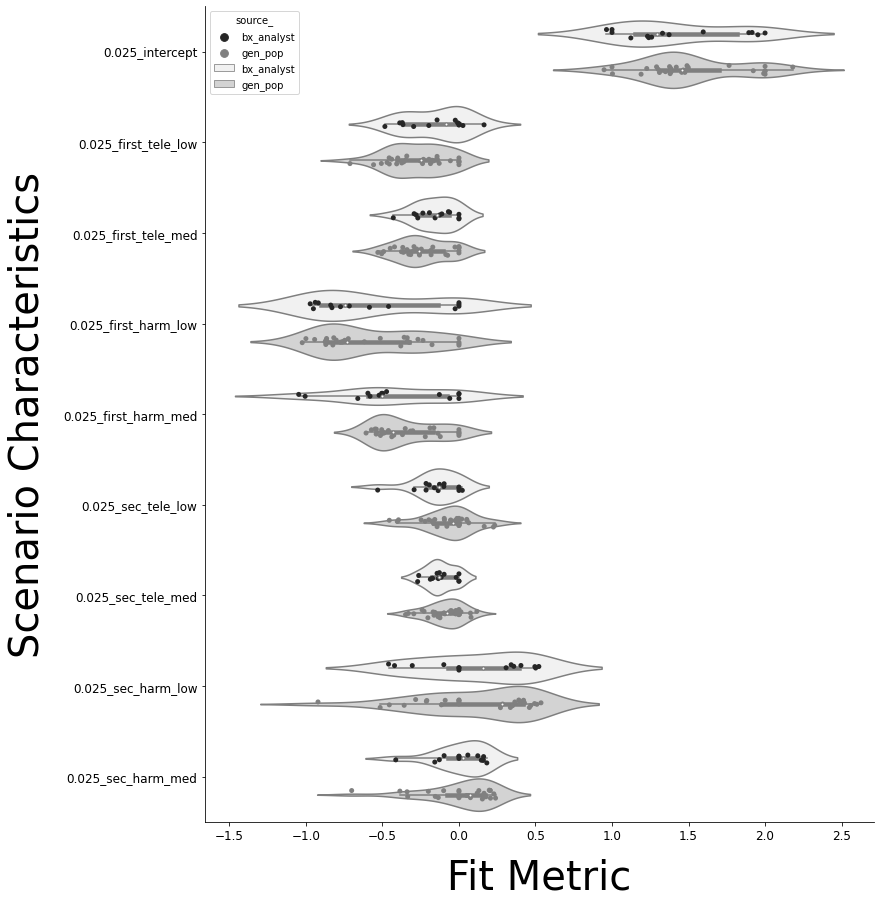

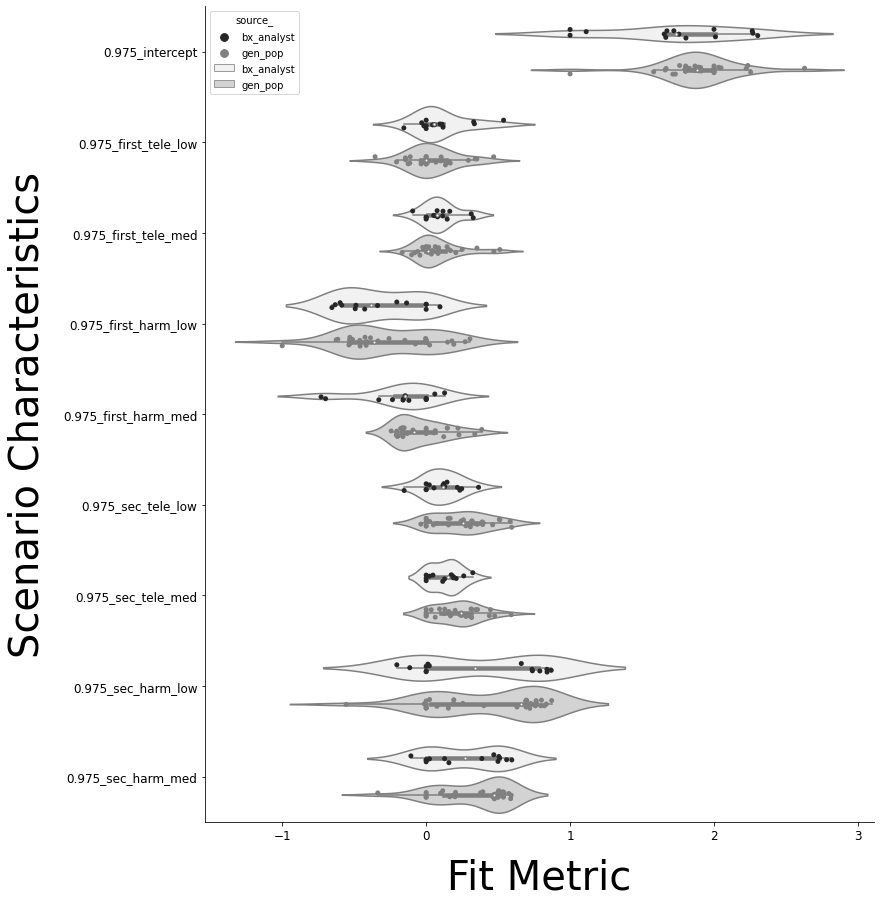

In [23]:
# Plot the different results
indiv_results = all_summary.melt(id_vars=['participant_', 'source_'])

# Get lists of variable values
coef = [val for val in indiv_results['variable'].unique() if val.startswith("coef")]
std_err = [val for val in indiv_results['variable'].unique() if val.startswith("std_err")]
t = [val for val in indiv_results['variable'].unique() if val.startswith("t_")]
p = [val for val in indiv_results['variable'].unique() if val.startswith("p>")]
o25 = [val for val in indiv_results['variable'].unique() if val.startswith("0.025")]
o975 = [val for val in indiv_results['variable'].unique() if val.startswith("0.975")]

for dataset in [coef, std_err, t, p, o25, o975]:
    fig, ax = plt.subplots(figsize=(12,15))
    sns.stripplot(x='value', y='variable', data=indiv_results[indiv_results['variable'].isin(dataset)], 
                  hue='source_', color='gray', dodge=True)
    sns.violinplot(x='value', y='variable', data=indiv_results[indiv_results['variable'].isin(dataset)], 
                  hue='source_', color='lightgray', split=False)
    plt.xlabel("Fit Metric", fontsize=40, labelpad=16)
    plt.ylabel("Scenario Characteristics", fontsize=40, labelpad=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(f'../figures/indiv_fits_summary_{dataset}.png', bbox_inches='tight')
    plt.show()

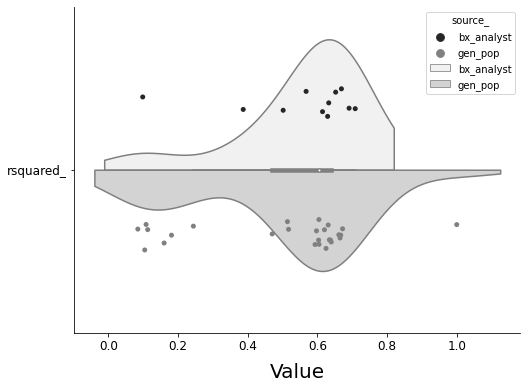

In [24]:
plot_df = indiv_results[indiv_results['variable']=='rsquared_']
plot_df['value'] = plot_df['value'].astype(str)
plot_df = plot_df.replace("inf", np.nan)
plot_df = plot_df.replace("-inf", np.nan)
plot_df['value'] = plot_df['value'].astype(float)
plot_df = plot_df.dropna(subset=['value']).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8,6))
sns.stripplot(x='value', y='variable', data=plot_df, 
              hue='source_', color='gray', dodge=True)
sns.violinplot(x='value', y='variable', data=plot_df, 
              hue='source_', color='lightgray', split=True, cut=True)
plt.xlabel("Value", fontsize=20, labelpad=10)
plt.ylabel("", fontsize=20, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(f'../figures/indiv_fits_summary_rsquared.png', bbox_inches='tight')
plt.show()

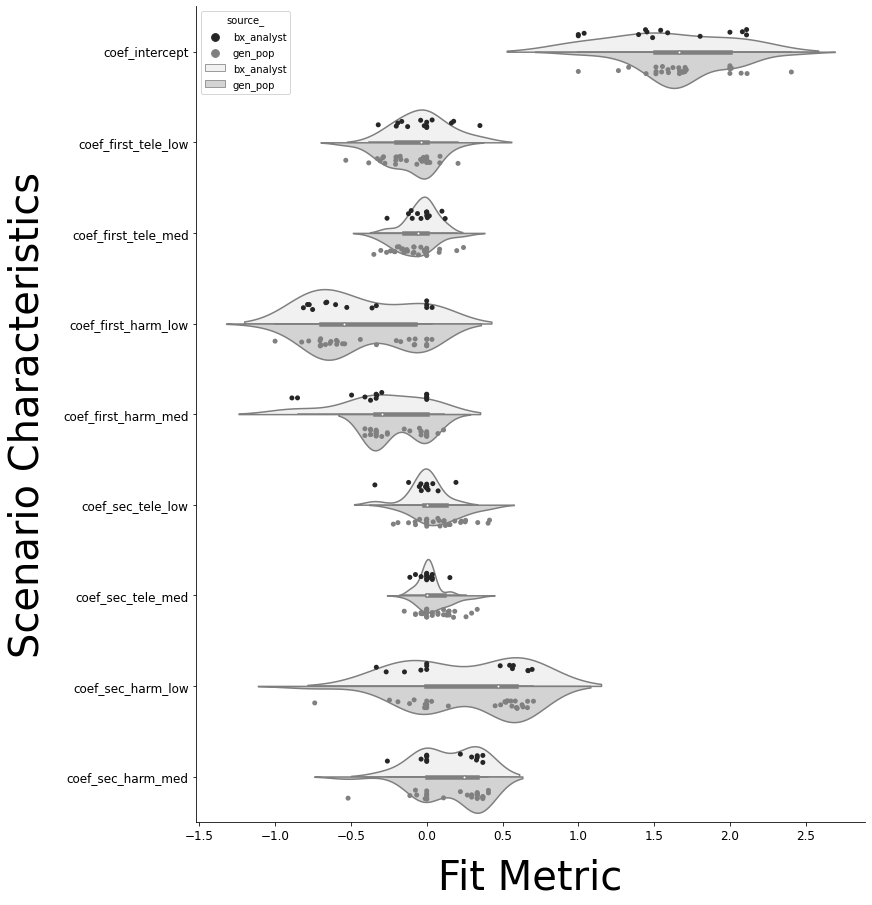

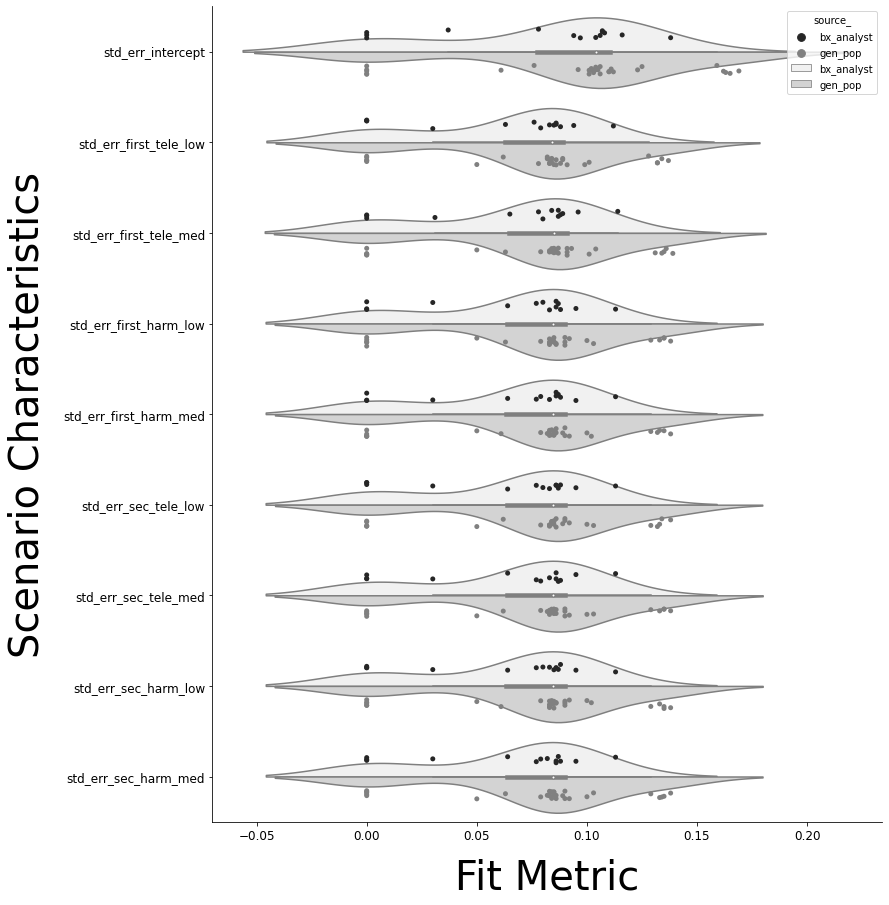

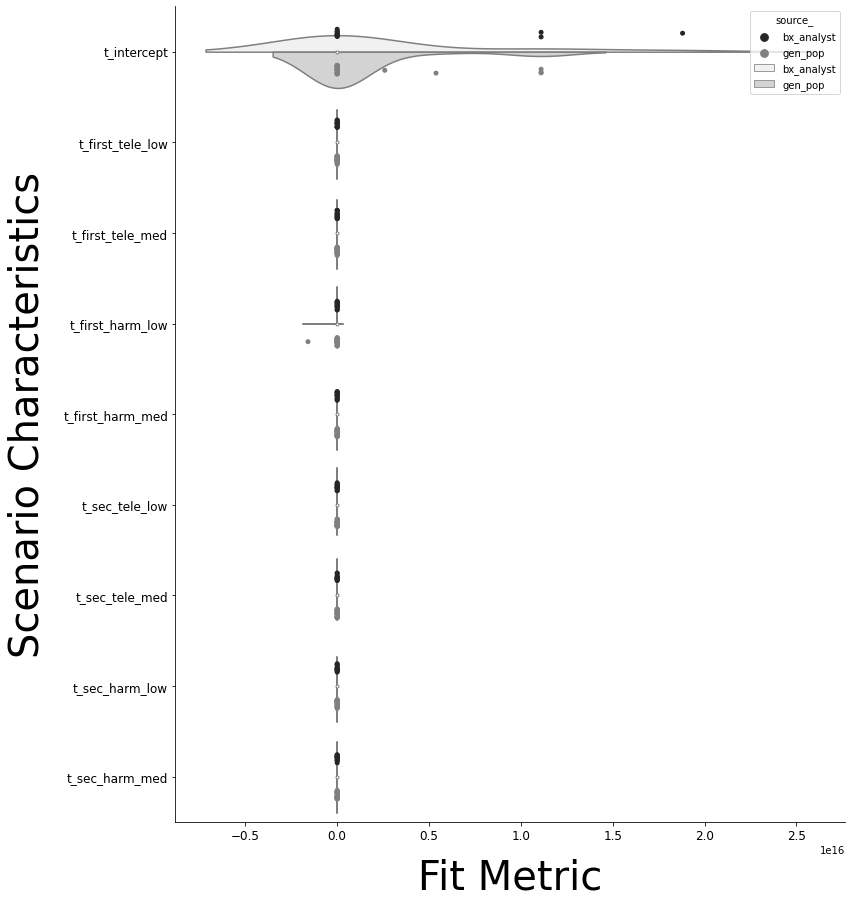

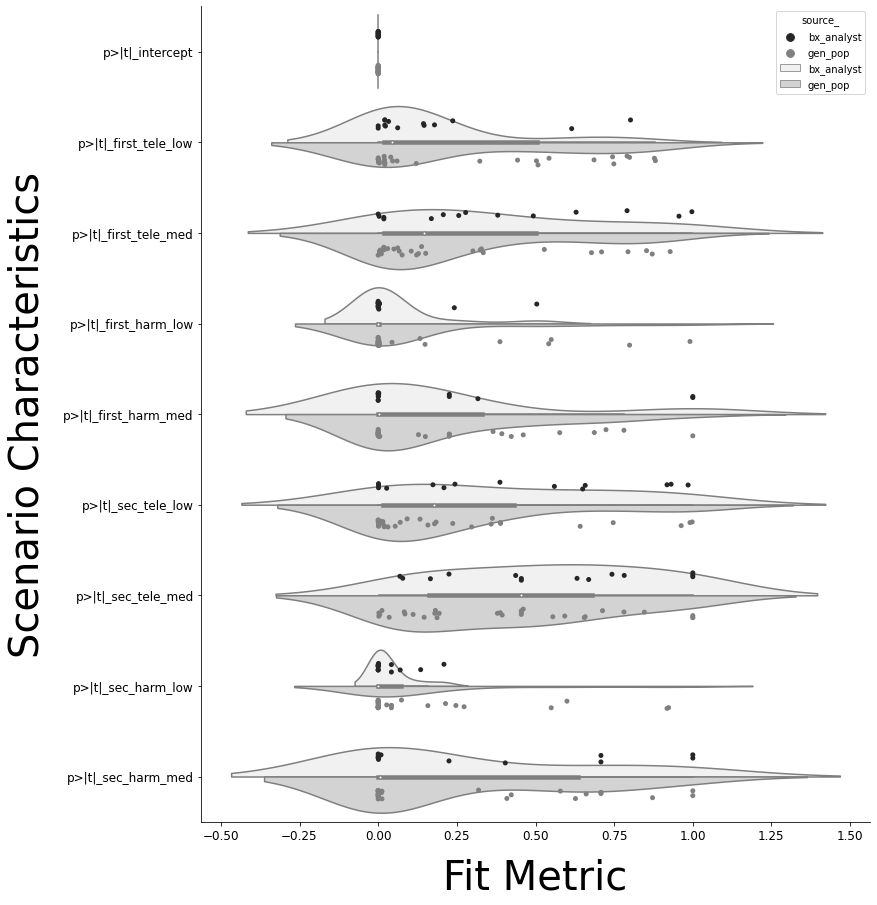

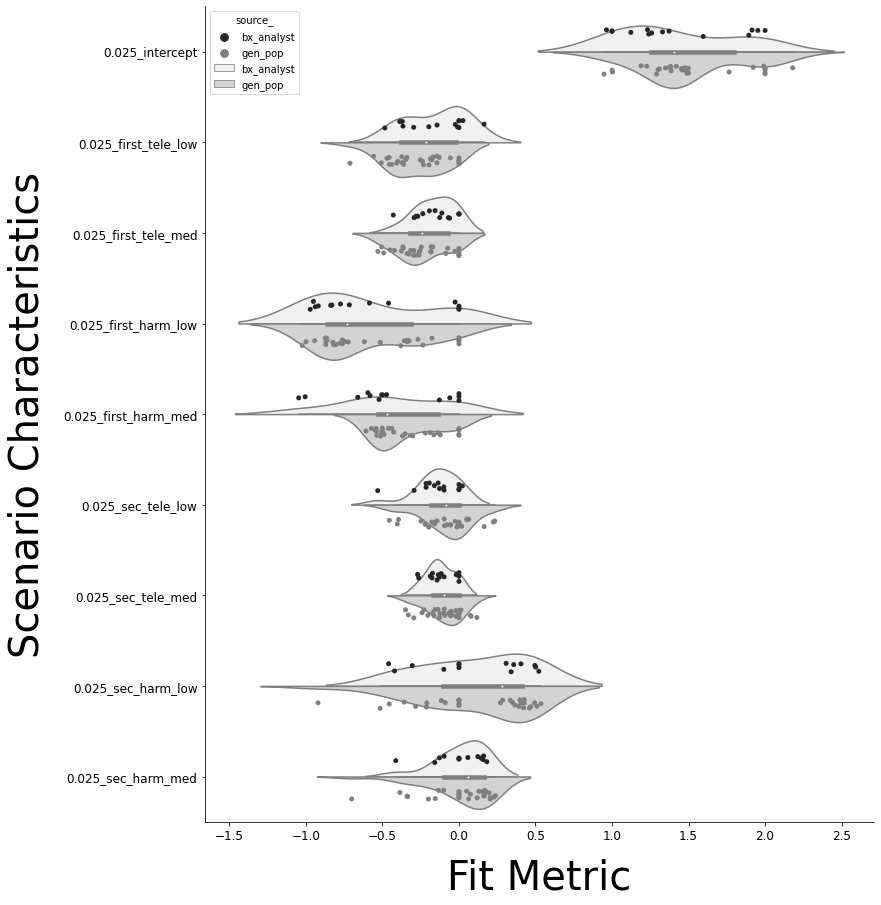

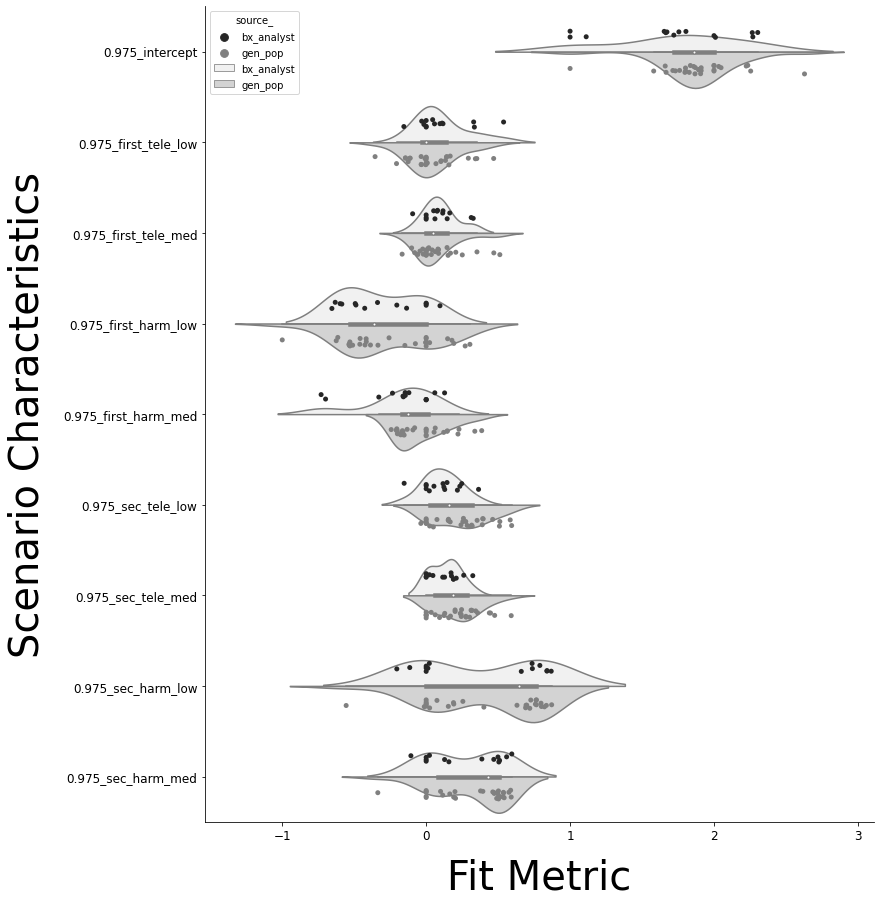

In [25]:
# Plot the different results
indiv_results = all_summary.melt(id_vars=['participant_', 'source_'])

# Get lists of variable values
coef = [val for val in indiv_results['variable'].unique() if val.startswith("coef")]
std_err = [val for val in indiv_results['variable'].unique() if val.startswith("std_err")]
t = [val for val in indiv_results['variable'].unique() if val.startswith("t_")]
p = [val for val in indiv_results['variable'].unique() if val.startswith("p>")]
o25 = [val for val in indiv_results['variable'].unique() if val.startswith("0.025")]
o975 = [val for val in indiv_results['variable'].unique() if val.startswith("0.975")]

for dataset in [coef, std_err, t, p, o25, o975]:
    fig, ax = plt.subplots(figsize=(12,15))
    sns.stripplot(x='value', y='variable', data=indiv_results[indiv_results['variable'].isin(dataset)], 
                  hue='source_', color='gray', dodge=True)
    sns.violinplot(x='value', y='variable', data=indiv_results[indiv_results['variable'].isin(dataset)], 
                  hue='source_', color='lightgray', split=True)
    plt.xlabel("Fit Metric", fontsize=40, labelpad=16)
    plt.ylabel("Scenario Characteristics", fontsize=40, labelpad=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(f'../figures/indiv_fits_summary_{dataset}_split.png', bbox_inches='tight')
    plt.show()